In [1]:
from __future__ import print_function, absolute_import
import argparse
import time
import os.path as osp
import os 
import numpy as np
import torch
from torch import nn
from torch.nn import init
from torch.backends import cudnn
from torch.utils.data import DataLoader
from reid import datasets
from reid import models
from reid.dist_metric import DistanceMetric
from reid.loss import TripletLoss, ClassificationLoss, RankingTripletLoss
from reid.trainers import PastTrainer, ClassificationTrainer
from reid.evaluators import Evaluator, extract_features, evaluate_all, pairwise_distance
from reid.utils.data import transforms as T
import torch.nn.functional as F
from reid.utils.data.preprocessor import Preprocessor
from reid.utils.data.sampler import RandomIdentitySampler, TripletSampler
from reid.utils.serialization import load_checkpoint, save_checkpoint

from hdbscan import HDBSCAN
from sklearn.preprocessing import normalize
#from h2o4gpu.cluster import KMeans
#from h2o4gpu.preprocessing import normalize
from reid.rerank import re_ranking, re_ranking2
from reid.st_model import ST_Model

import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
def get_data(name, data_dir, height, width, batch_size,
             workers):
    root = osp.join(data_dir, name)

    dataset = datasets.create(name, root, num_val=0.1)

    normalizer = T.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])

    # use all training and validation images in target dataset
    train_set = dataset.trainval 
    num_classes = dataset.num_trainval_ids

    transformer = T.Compose([
        T.Resize((height,width)),
        T.ToTensor(),
        normalizer,
    ])

    extfeat_loader = DataLoader(
        Preprocessor(train_set, root=dataset.images_dir,
                     transform=transformer),
        batch_size=batch_size, num_workers=workers,
        shuffle=False, pin_memory=True)

    test_loader = DataLoader(
        Preprocessor(list(set(dataset.query) | set(dataset.gallery)),
                     root=dataset.images_dir, transform=transformer),
        batch_size=batch_size//2, num_workers=workers,
        shuffle=False, pin_memory=True)

    return dataset, num_classes, extfeat_loader, test_loader


def get_source_data(name, data_dir, height, width, batch_size, workers):
    root = osp.join(data_dir, name)

    dataset = datasets.create(name, root, num_val=0.1)

    normalizer = T.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])

    # use all training images on source dataset
    train_set = dataset.train
    num_classes = dataset.num_train_ids

    transformer = T.Compose([
        T.Resize((height,width)),
        T.ToTensor(),
        normalizer,
    ])

    extfeat_loader = DataLoader(
        Preprocessor(train_set, root=dataset.images_dir,
                     transform=transformer),
        batch_size=batch_size, num_workers=workers,
        shuffle=False, pin_memory=True)

    return dataset, extfeat_loader

In [3]:
parser = argparse.ArgumentParser(description="Triplet loss classification")
# data
parser.add_argument('--src_dataset', type=str, default='dukemtmc',
                    choices=datasets.names())
parser.add_argument('--tgt_dataset', type=str, default='market1501',
                    choices=datasets.names())
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--workers', type=int, default=4)
parser.add_argument('--split', type=int, default=0)
parser.add_argument('--noiseLam', type=float, default=0.5)
parser.add_argument('--height', type=int,
                    help="input height, default: 256 for resnet*, "
                         "144 for inception")
parser.add_argument('--width', type=int,
                    help="input width, default: 128 for resnet*, "
                         "56 for inception")
parser.add_argument('--combine-trainval', action='store_true',
                    help="train and val sets together for training, "
                         "val set alone for validation")
parser.add_argument('--num_instances', type=int, default=4,
                    help="each minibatch consist of "
                         "(batch_size // num_instances) identities, and "
                         "each identity has num_instances instances, "
                         "default: 4")
# model
parser.add_argument('--arch', type=str, default='resnet50',
                    choices=models.names())
# loss
parser.add_argument('--margin', type=float, default=0.3,
                    help="margin of the triplet loss, default: 0.3")
parser.add_argument('--lambda_value', type=float, default=0.1,
                    help="balancing parameter, default: 0.1")
parser.add_argument('--rho', type=float, default=1.6e-3,
                    help="rho percentage, default: 1.6e-3")
# optimizer
parser.add_argument('--lr', type=float, default=5e-5,
                    help="learning rate of all parameters")
# training configs
parser.add_argument('--resume', type=str, metavar='PATH',
                    default = '')
parser.add_argument('--evaluate', type=int, default=0,
                    help="evaluation only")
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--print_freq', type=int, default=1)
parser.add_argument('--iteration', type=int, default=10)
parser.add_argument('--epochs', type=int, default=80)
# metric learning
parser.add_argument('--dist_metric', type=str, default='euclidean',
                    choices=['euclidean', 'kissme'])
# misc
parser.add_argument('--data_dir', type=str, metavar='PATH',
                    default='')
parser.add_argument('--logs_dir', type=str, metavar='PATH',
                    default='')

args = parser.parse_args(['--src_dataset', 'market1501', '--tgt_dataset', 'dukemtmc', '--resume', 'ACT_pretrain/logMar/adaM2D.pth', '--data_dir', './data', '--logs_dir', './log/M2D'])

In [5]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
cudnn.benchmark = True

# Create data loaders
assert args.num_instances > 1, "num_instances should be greater than 1"
assert args.batch_size % args.num_instances == 0, \
    'num_instances should divide batch_size'
if args.height is None or args.width is None:
    args.height, args.width = (144, 56) if args.arch == 'inception' else \
                              (256, 128)

# get source data
src_dataset, src_extfeat_loader = \
    get_source_data(args.src_dataset, args.data_dir, args.height,
                    args.width, args.batch_size, args.workers)
# get target data
tgt_dataset, num_classes, tgt_extfeat_loader, test_loader = \
    get_data(args.tgt_dataset, args.data_dir, args.height,
             args.width, args.batch_size, args.workers)

# Create model
# Hacking here to let the classifier be the number of source ids
if args.src_dataset == 'dukemtmc':
    model = models.create(args.arch, num_classes=632, pretrained=False)
elif args.src_dataset == 'market1501':
    model = models.create(args.arch, num_classes=676, pretrained=False)
else:
    raise RuntimeError('Please specify the number of classes (ids) of the network.')

# Load from checkpoint
if args.resume:
    print('Resuming checkpoints from finetuned model on another dataset...\n')
#     checkpoint = load_checkpoint(args.resume)
    checkpoint = load_checkpoint('log/M2D/model_best.pth.tar')
    model.load_state_dict(checkpoint['state_dict'], strict=False)
else:
    raise RuntimeWarning('Not using a pre-trained model.')
model = nn.DataParallel(model).cuda()

# evaluator.evaluate(test_loader, tgt_dataset.query, tgt_dataset.gallery)
# if args.evaluate: return

# Criterion
criterion = [
    TripletLoss(args.margin, args.num_instances, isAvg=True, use_semi=True).cuda(),
    TripletLoss(args.margin, args.num_instances, isAvg=True, use_semi=True).cuda(),
    None, None
]


# Optimizer
optimizer = torch.optim.Adam(
    model.parameters(), lr=args.lr
)


# training stage transformer on input images
normalizer = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transformer = T.Compose([
    T.Resize((args.height,args.width)),
    T.RandomHorizontalFlip(),
    T.ToTensor(), normalizer,
    T.RandomErasing(probability=0.5, sh=0.2, r1=0.3)
])

Files already downloaded and verified
Market1501 dataset loaded
  subset   | # ids | # images
  ---------------------------
  train    |   676 |    11744
  val      |    75 |     1192
  trainval |   751 |    12936
  query    |   750 |     3368
  gallery  |   751 |    15913
Files already downloaded and verified
DukeMTMC dataset loaded
  subset   | # ids | # images
  ---------------------------
  train    |   632 |    14923
  val      |    70 |     1599
  trainval |   702 |    16522
  query    |   702 |     2228
  gallery  |  1110 |    17661
Resuming checkpoints from finetuned model on another dataset...

=> Loaded checkpoint 'log/M2D/model_best.pth.tar'


In [ ]:
# evaluator = Evaluator(model, print_freq=args.print_freq)
# evaluator.evaluate(test_loader, tgt_dataset.query, tgt_dataset.gallery)

## Training Stage

In [6]:
# get source datas' feature
source_features, _ = extract_features(model, src_extfeat_loader, print_freq=args.print_freq)
# synchronization feature order with src_dataset.train
source_features = torch.cat([source_features[f].unsqueeze(0) for f, _, _, _ in src_dataset.train], 0)

In [7]:
target_features, tarNames = extract_features(model, tgt_extfeat_loader, print_freq=args.print_freq)
# synchronization feature order with dataset.train
target_features = torch.cat([target_features[f].unsqueeze(0) for f, _, _, _ in tgt_dataset.trainval], 0)

In [8]:
def calDis(qFeature, gFeature, norm=False):#246s
    x, y = qFeature, gFeature
    if norm:
        x, y = F.normalize(x), F.normalize(y)
    m, n = x.shape[0], y.shape[0]
    disMat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(m, n) + \
             torch.pow(y, 2).sum(dim=1, keepdim=True).expand(n, m).t()
    disMat.addmm_(1, -2, x, y.t())
    return disMat.clamp_(min=1e-5)

In [9]:
original_dist = calDis(torch.tensor(target_features), torch.tensor(target_features))

/scratch/sunzc/.conda/envs/act/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [36]:
# norm_dist = calDis(torch.tensor(target_features), torch.tensor(target_features), norm=True)

In [10]:
target_features = target_features.numpy()
rerank_dist = re_ranking(source_features, target_features, lambda_value=args.lambda_value)

Computing source distance...
-----* Distance Matrix has been computed*-----
Computing original distance...
-----* Distance Matrix has been computed*-----
done...
Starting re_ranking...


In [8]:
def plot_same_dist(dataset, distmat, sample_num=1000000):
    cluster_by_pid = {}
    for i, (_, pid, _, _) in enumerate(dataset):
        if pid not in cluster_by_pid:
            cluster_by_pid[pid] = []
        cluster_by_pid[pid].append(i)
    
    dists = []
    for cluster in cluster_by_pid.values():
        l = len(cluster)
        for i in range(l):
            for j in range(i):
                dists.append(distmat[cluster[i]][cluster[j]])
                
    x = sample_num // distmat.shape[1]
    dist2 = distmat[:x, :].flatten()
    
    plt.figure()
    sns.distplot(dists)
    sns.distplot(dist2)

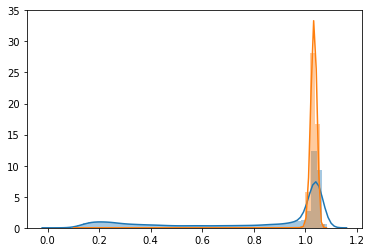

In [15]:
# plot_same_dist(tgt_dataset.trainval, rerank_dist)

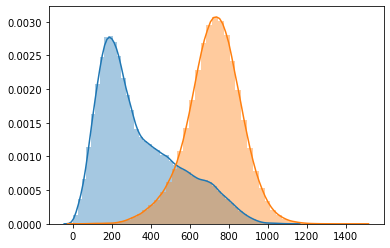

In [16]:
# plot_same_dist(tgt_dataset.trainval, original_dist)

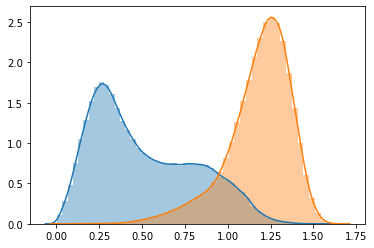

In [37]:
plot_same_dist(tgt_dataset.trainval, norm_dist)

## Test Stage

In [11]:
from reid.evaluators import pairwise_distance
# from reid.rerank import re_ranking2

features, _ = extract_features(model, test_loader, print_freq=args.print_freq)

distmat = pairwise_distance(features, tgt_dataset.query, tgt_dataset.gallery, metric=None)
distmat_qq = pairwise_distance(features, tgt_dataset.query, tgt_dataset.query, metric=None)
distmat_gg = pairwise_distance(features, tgt_dataset.gallery, tgt_dataset.gallery, metric=None)

distmat2 = re_ranking2(distmat.numpy(), distmat_qq.numpy(), distmat_gg.numpy())

In [28]:
# def pairwise_distance_norm(features, query=None, gallery=None, metric=None):
#     x = torch.cat([features[f].unsqueeze(0) for f, _, _, _ in query], 0)
#     y = torch.cat([features[f].unsqueeze(0) for f, _, _, _ in gallery], 0)
#     x = F.normalize(x)
#     y = F.normalize(y)
#     m, n = x.size(0), y.size(0)
#     x = x.view(m, -1)
#     y = y.view(n, -1)
#     if metric is not None:
#         x = metric.transform(x)
#         y = metric.transform(y)
#     dist = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(m, n) + \
#            torch.pow(y, 2).sum(dim=1, keepdim=True).expand(n, m).t()
#     dist.addmm_(1, -2, x, y.t())
#     return dist

# distmat_norm = pairwise_distance_norm(features, tgt_dataset.query, tgt_dataset.gallery, metric=None)

In [38]:
# s = evaluate_all(distmat_norm, tgt_dataset.query, tgt_dataset.gallery)

Mean AP: 49.4%
CMC Scores    allshots      cuhk03  market1501
  top-1          33.3%       51.8%       67.7%
  top-5          45.8%       68.4%       80.3%
  top-10         51.5%       74.3%       83.4%


In [47]:
# from reid.rerank import re_ranking2
# distmat2 = re_ranking2(distmat.numpy(), distmat_qq.numpy(), distmat_gg.numpy())

In [29]:
# def plot_dist(distmat, sample_num=1000000):
#     x = sample_num // distmat.shape[1]
#     dists = distmat[:x, :].flatten()
#     plt.figure()
#     sns.distplot(dists)

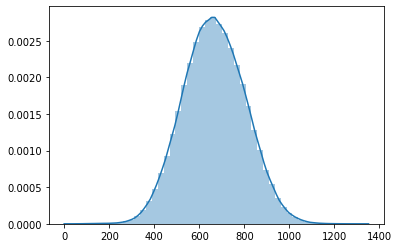

In [8]:
# plot_dist(distmat)

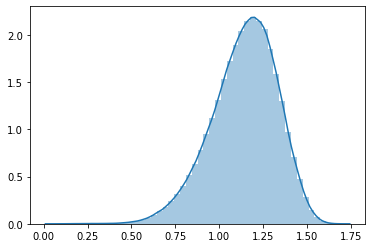

In [30]:
# plot_dist(distmat_norm)

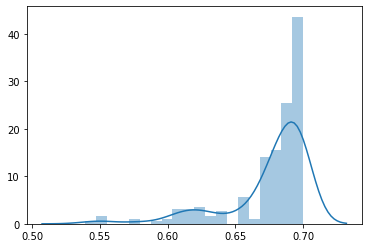

In [9]:
# plot_dist(distmat2)

In [12]:
st_model = ST_Model(tgt_dataset.meta['num_cameras'])

same, total = st_model.fit(tgt_dataset.trainval)

In [13]:
st_model2 = ST_Model(tgt_dataset.meta['num_cameras'])

cluster = HDBSCAN(metric='precomputed', min_samples=10)
# select & cluster images as training set of this epochs
clusterRes = cluster.fit(rerank_dist)
labels, label_num = clusterRes.labels_, clusterRes.labels_.max() + 1
centers = np.zeros((label_num, target_features.shape[1]))
nums = [0] * target_features.shape[1]
print('clusters num =', label_num)

# generate new dataset
new_dataset = []
index = -1
for (fname, _, cam, timestamp), label in zip(tgt_dataset.trainval, labels):
    index += 1
    if label == -1: continue
    # dont need to change codes in trainer.py _parsing_input function and sampler function after add 0
    new_dataset.append((fname, label, cam, timestamp))
    centers[label] += target_features[index]
    nums[label] += 1

same2, total2 = st_model2.fit(new_dataset)

clusters num = 795


In [14]:
labels, label_num = clusterRes.labels_, clusterRes.labels_.max() + 1
centers = np.zeros((label_num, target_features.shape[1]))
nums = [0] * target_features.shape[1]

# generate new dataset
new_dataset = []
index = -1
for (fname, pid, cam, timestamp), label in zip(tgt_dataset.trainval, labels):
    index += 1
    if label == -1: continue
    # dont need to change codes in trainer.py _parsing_input function and sampler function after add 0
    new_dataset.append((pid, label, cam, timestamp))
    centers[label] += target_features[index]
    nums[label] += 1

In [6]:
# st_model.same_rate

0.00268445230806414

In [30]:
# def print_gmm(i, j):
#     plt.figure()
#     gmm_map = {'gt': st_model.probs[i][j], 'fit': st_model2.probs[i][j]}
#     for gmm_key in gmm_map:
#         g = gmm_map[gmm_key].toGaussianMixture()
#         vals = g.sample(10000)[0].squeeze(1)
#         sns.distplot(vals)

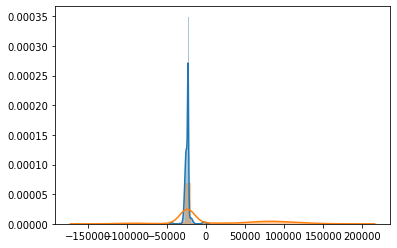

In [33]:
# print_gmm(2, 1)

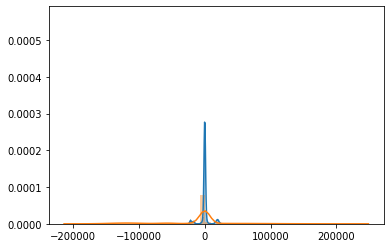

In [32]:
# print_gmm(2, 2)

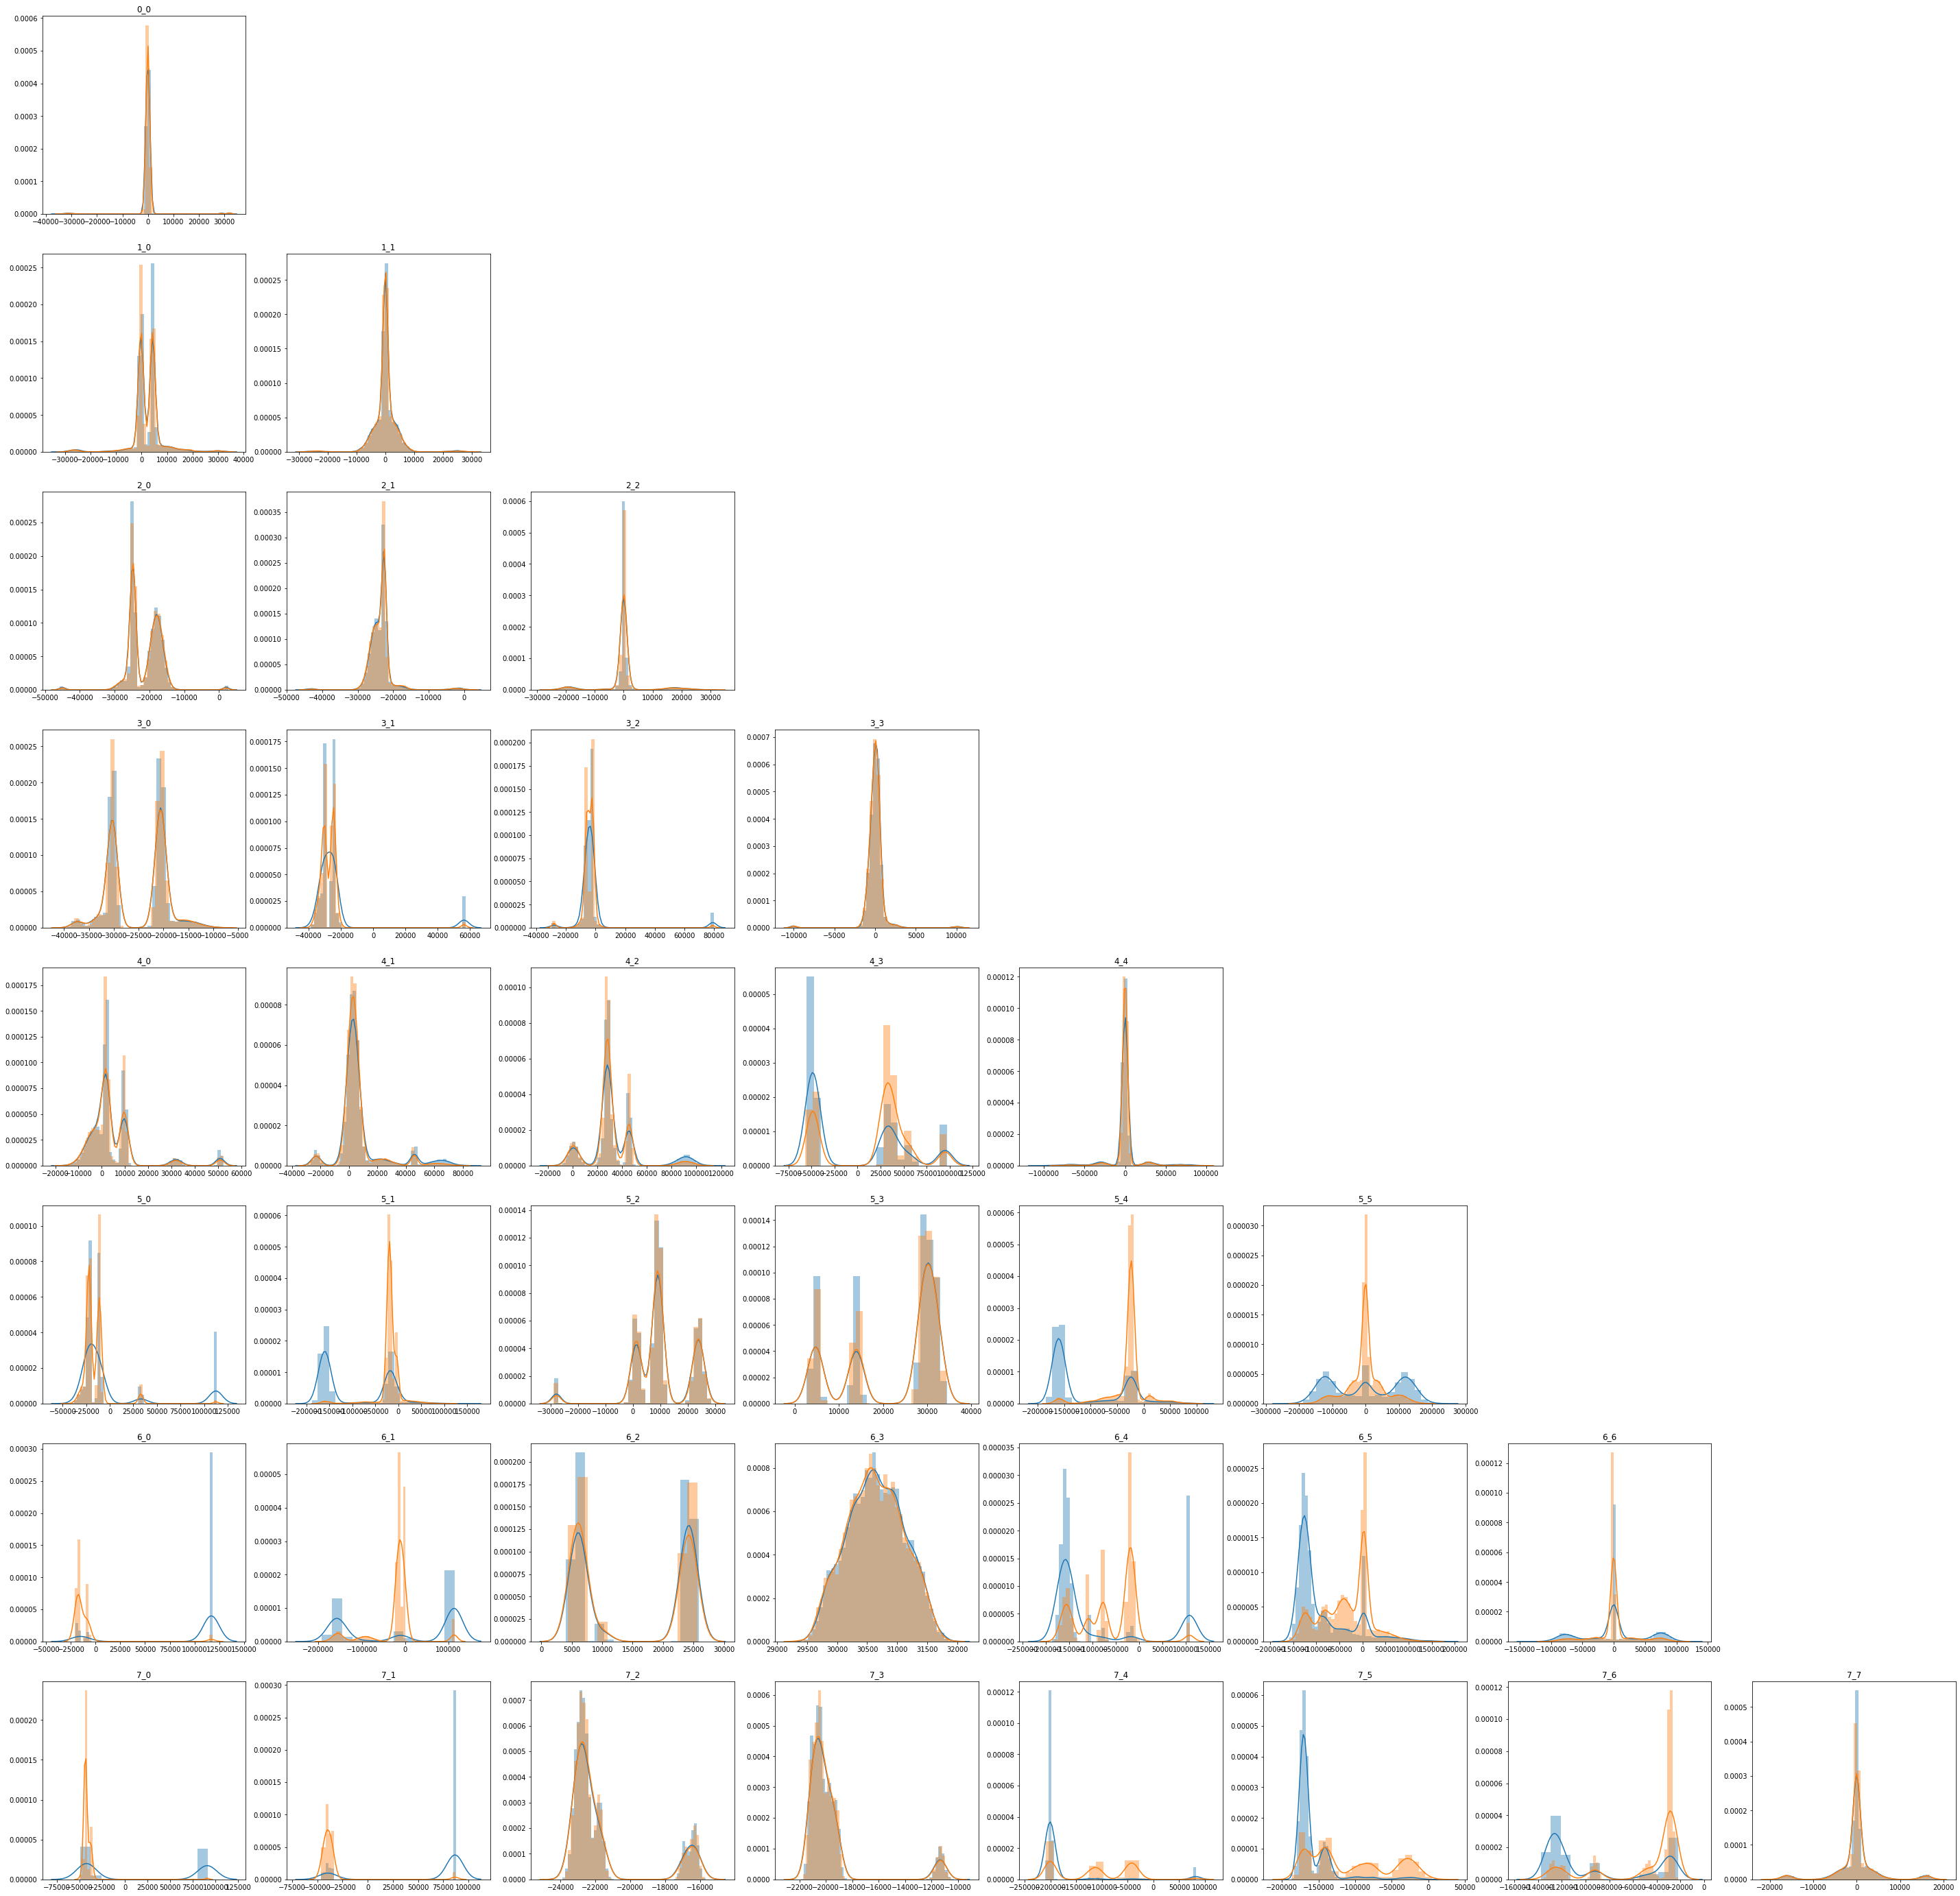

In [10]:
# def get_gmm(i, j):
#     g1 = st_model.probs[i][j].toGaussianMixture()
#     vals1 = g1.sample(10000)[0].squeeze(1)
# #     g2 = st_model2.probs[i][j].toGaussianMixture()
#     g2 = same.fits[i][j].toGaussianMixture()
#     vals2 = g2.sample(10000)[0].squeeze(1)
#     return vals1, vals2

# plt.figure(figsize=(50,50))
# cam_num = st_model.cam_num
# for i in range(cam_num):
#     for j in range(i+1):
#         plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
#         # plot delta
#         d1, d2 = get_gmm(i, j)
#         sns.distplot(d1)
#         sns.distplot(d2)
#         plt.title('%d_%d' % (i, j))
# plt.show()

In [11]:
# import numpy as np
# from sklearn.neighbors import NearestNeighbors
# from scipy.spatial import KDTree


# def knn_distance(point, sample, k):
#     """ Euclidean distance from `point` to it's `k`-Nearest
#     Neighbour in `sample` """
#     norms = np.linalg.norm(sample-point, axis=1)
#     return np.sort(norms)[k]


# def verify_sample_shapes(s1, s2, k):
#     # Expects [N, D]
#     assert(len(s1.shape) == len(s2.shape) == 2)
#     # Check dimensionality of sample is identical
#     assert(s1.shape[1] == s2.shape[1])


# def naive_estimator(s1, s2, k=1):
#     """ KL-Divergence estimator using brute-force (numpy) k-NN
#         s1: (N_1,D) Sample drawn from distribution P
#         s2: (N_2,D) Sample drawn from distribution Q
#         k: Number of neighbours considered (default 1)
#         return: estimated D(P|Q)
#     """
#     verify_sample_shapes(s1, s2, k)

#     n, m = len(s1), len(s2)
#     D = np.log(m / (n - 1))
#     d = float(s1.shape[1])

#     for p1 in s1:
#         nu = knn_distance(p1, s2, k-1)  # -1 because 'p1' is not in 's2'
#         rho = knn_distance(p1, s1, k)
#         D += (d/n)*np.log(nu/rho)
#     return D

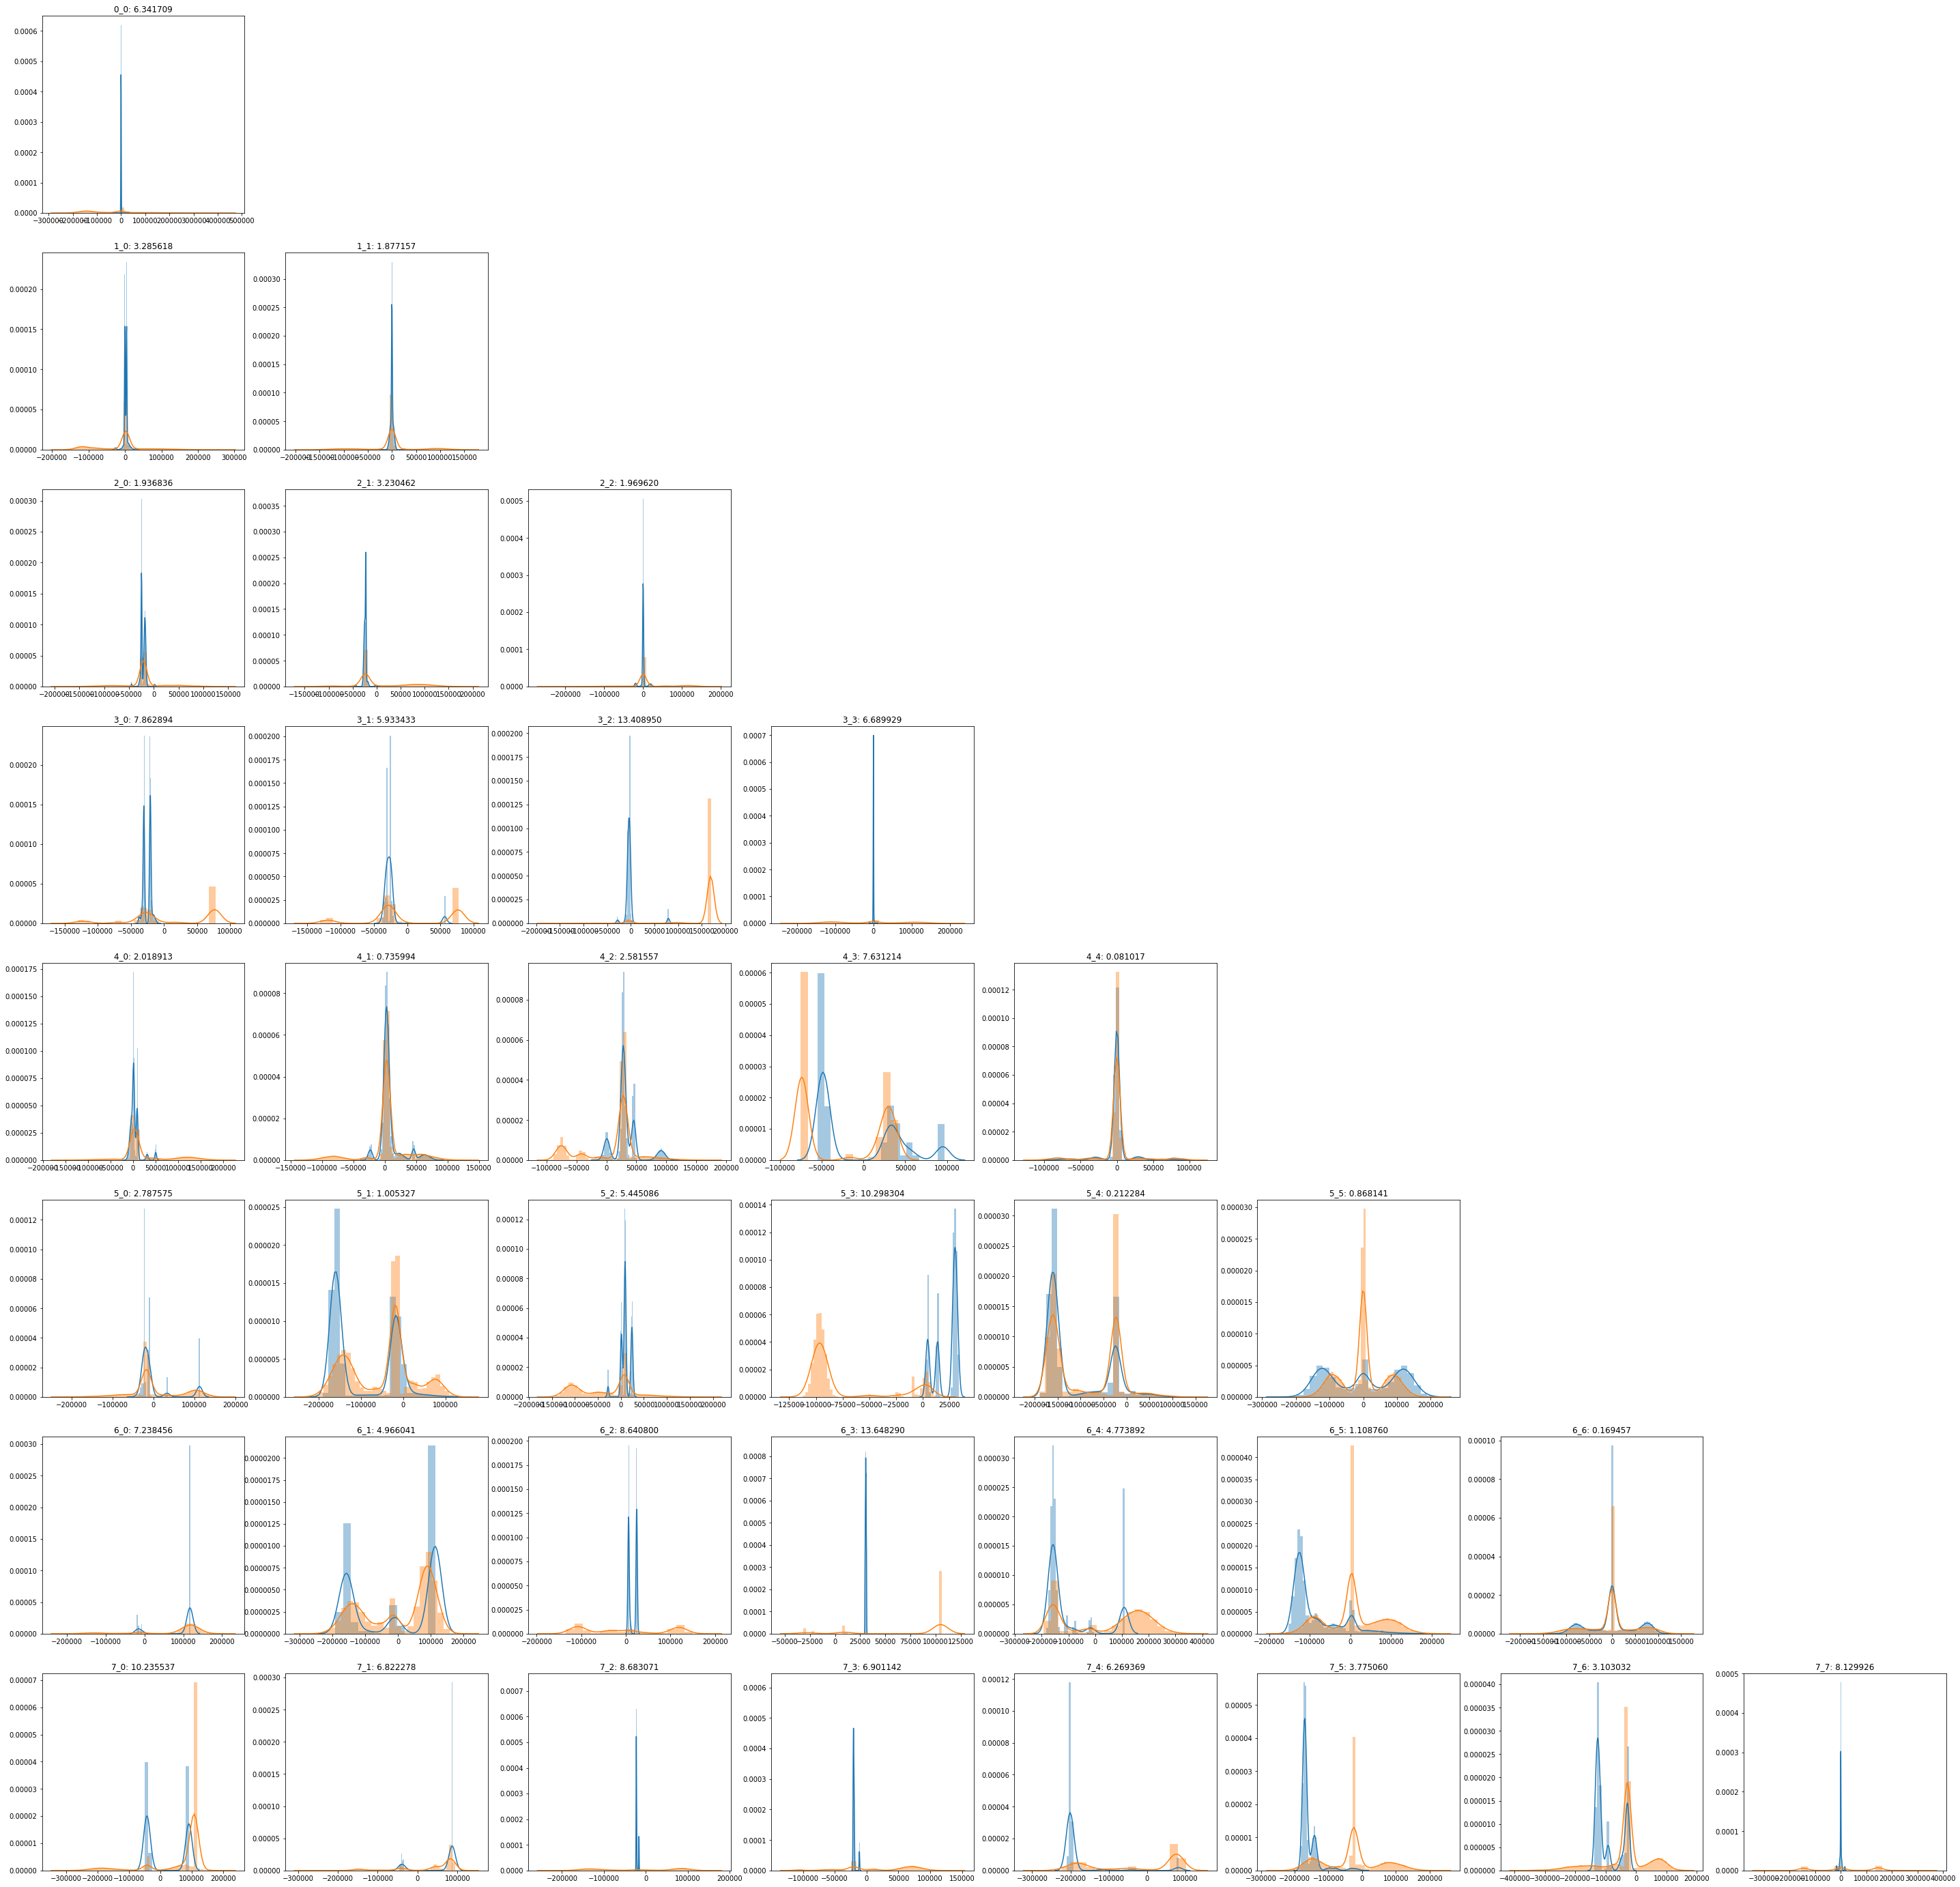

In [12]:
# def get_gmm(i, j):
#     g1 = st_model.probs[i][j].toGaussianMixture()
#     vals1 = g1.sample(10000)[0]
#     g2 = st_model2.probs[i][j].toGaussianMixture()
# #     g2 = same.fits[i][j].toGaussianMixture()
#     vals2 = g2.sample(10000)[0]
#     return vals1, vals2

# plt.figure(figsize=(50,50))
# cam_num = st_model.cam_num
# for i in range(cam_num):
#     for j in range(i+1):
#         plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
#         # plot delta
#         d1, d2 = get_gmm(i, j)
#         sns.distplot(d1.squeeze(1))
#         sns.distplot(d2.squeeze(1))
#         plt.title('%d_%d: %f' % (i, j, naive_estimator(d2, d1)))
# plt.show()

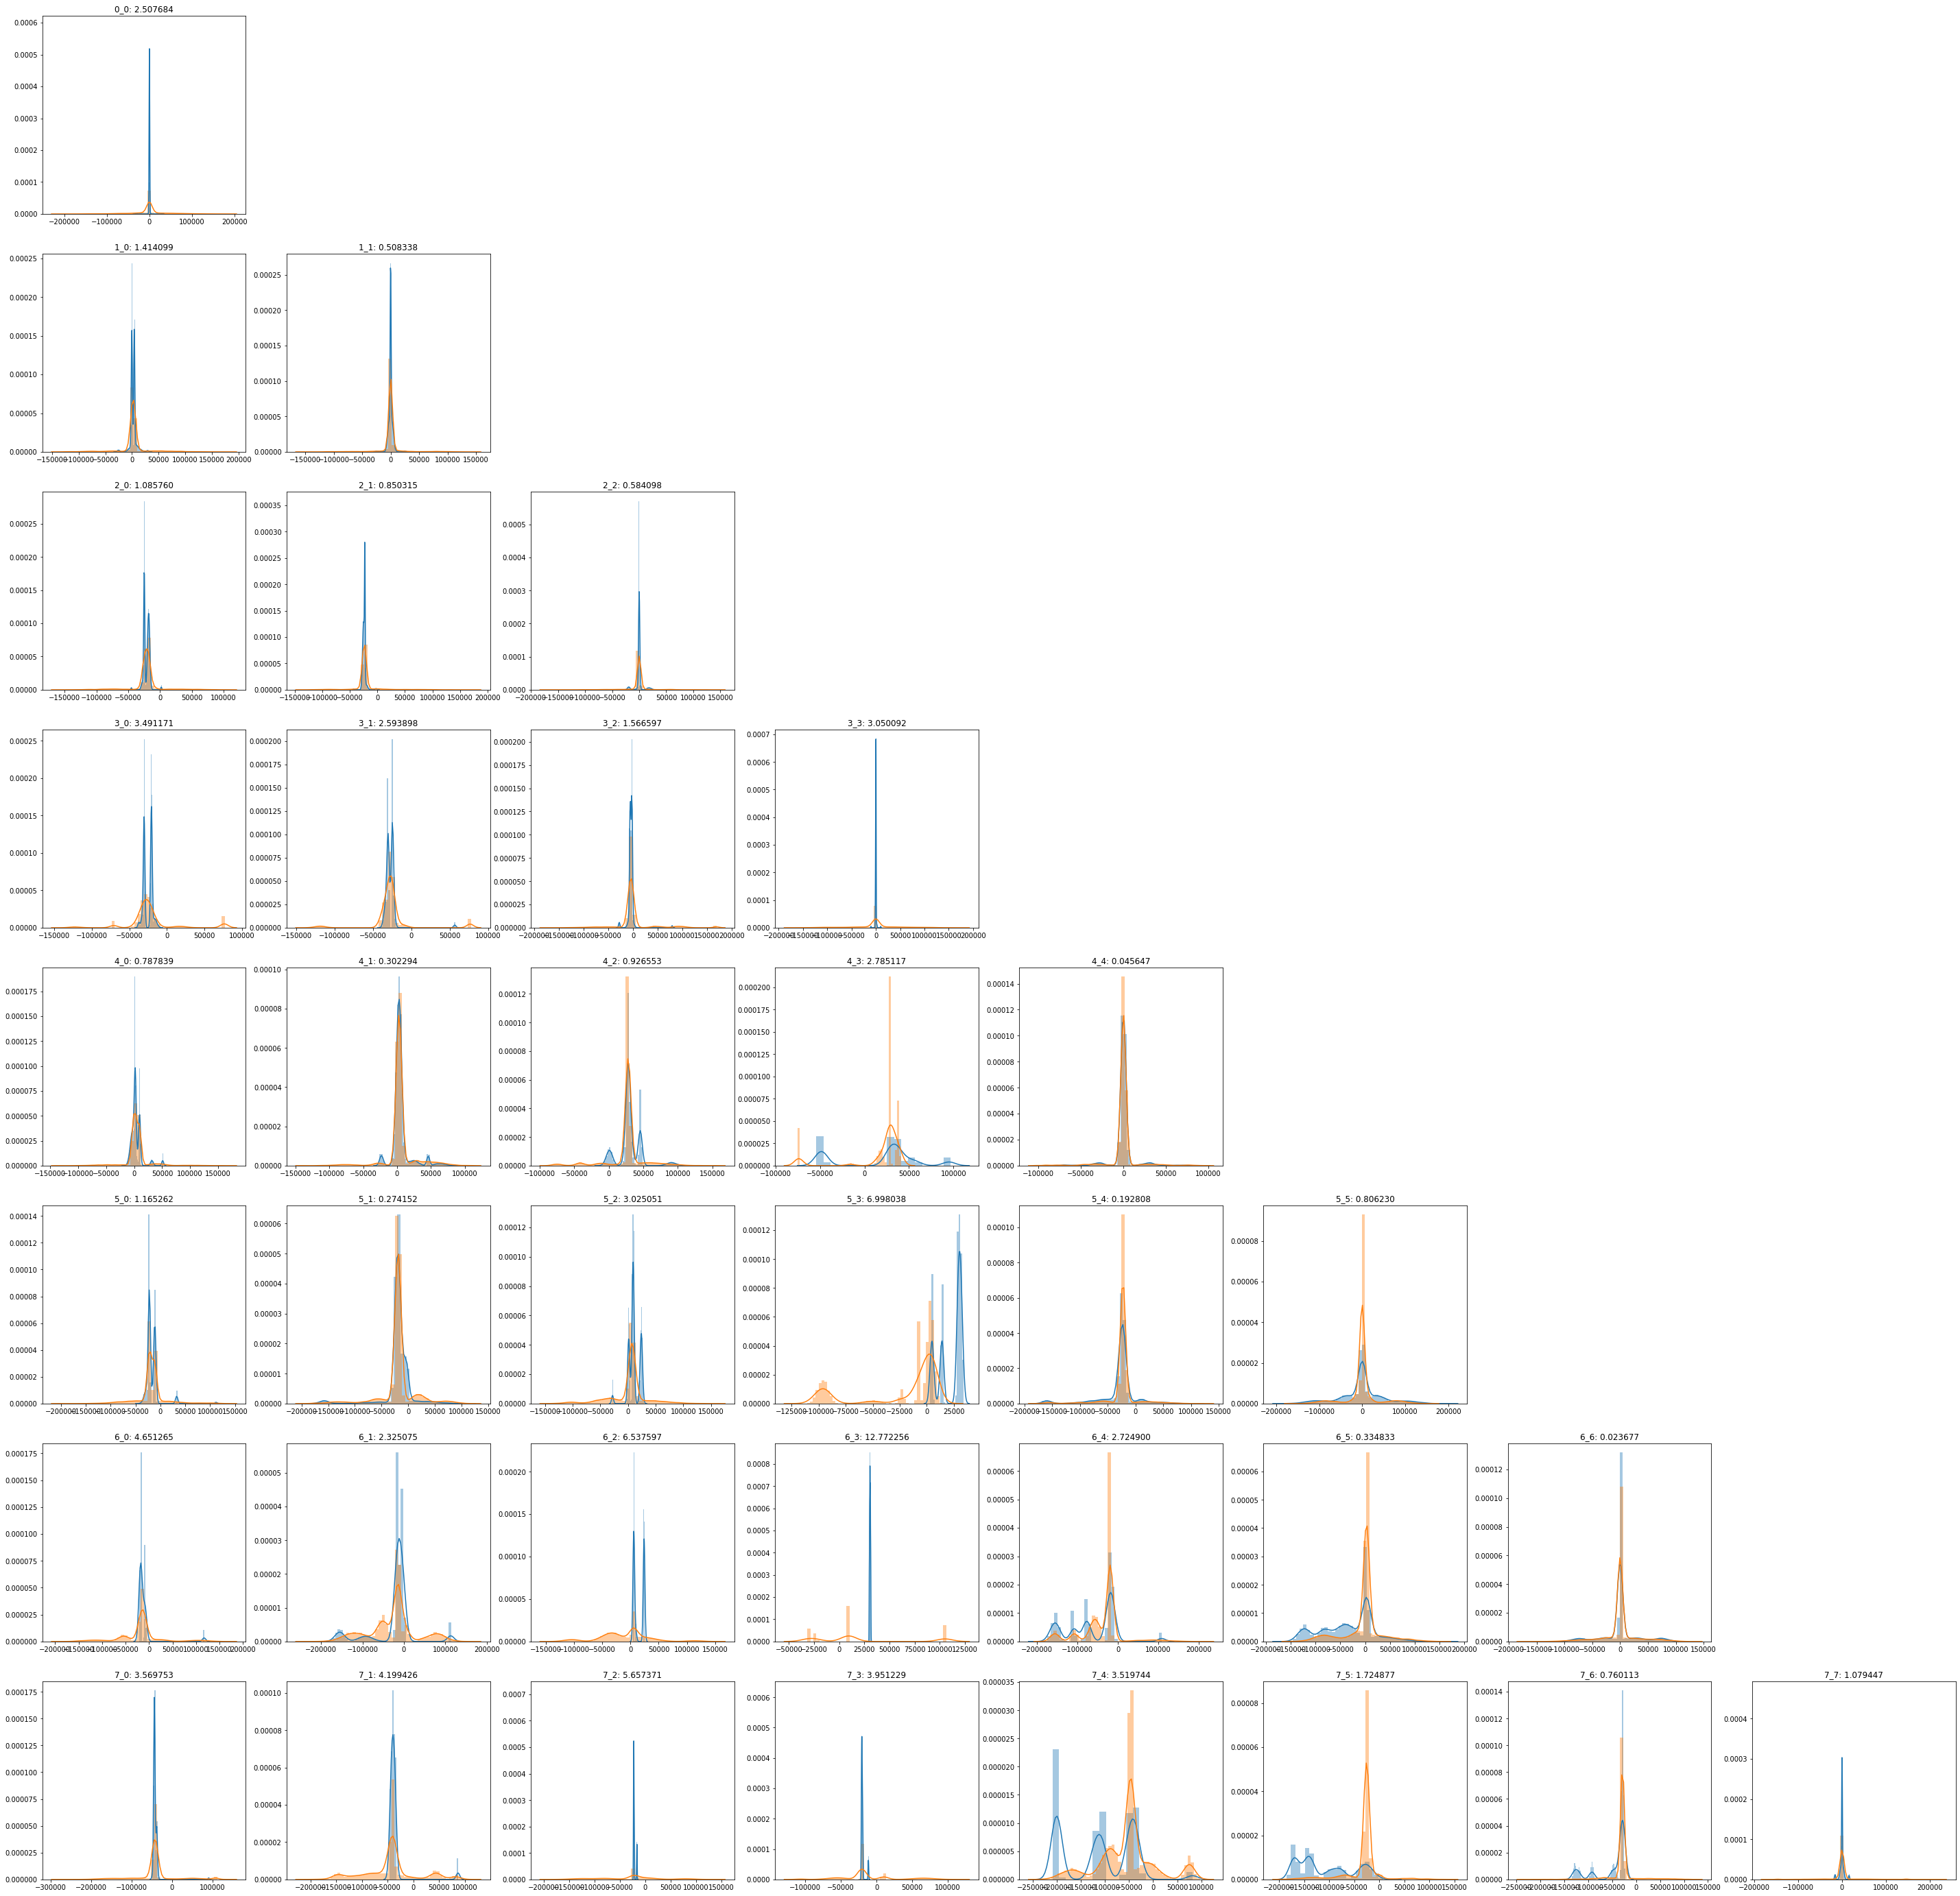

In [13]:
# def get_gmm2(i, j):
#     g1 = same.fits[i][j].toGaussianMixture()
#     vals1 = g1.sample(10000)[0]
#     g2 = same2.fits[i][j].toGaussianMixture()
# #     g2 = same.fits[i][j].toGaussianMixture()
#     vals2 = g2.sample(10000)[0]
#     return vals1, vals2

# plt.figure(figsize=(50,50))
# cam_num = st_model.cam_num
# for i in range(cam_num):
#     for j in range(i+1):
#         plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
#         # plot delta
#         d1, d2 = get_gmm2(i, j)
#         sns.distplot(d1.squeeze(1))
#         sns.distplot(d2.squeeze(1))
#         plt.title('%d_%d: %f' % (i, j, naive_estimator(d2, d1)))
# plt.show()

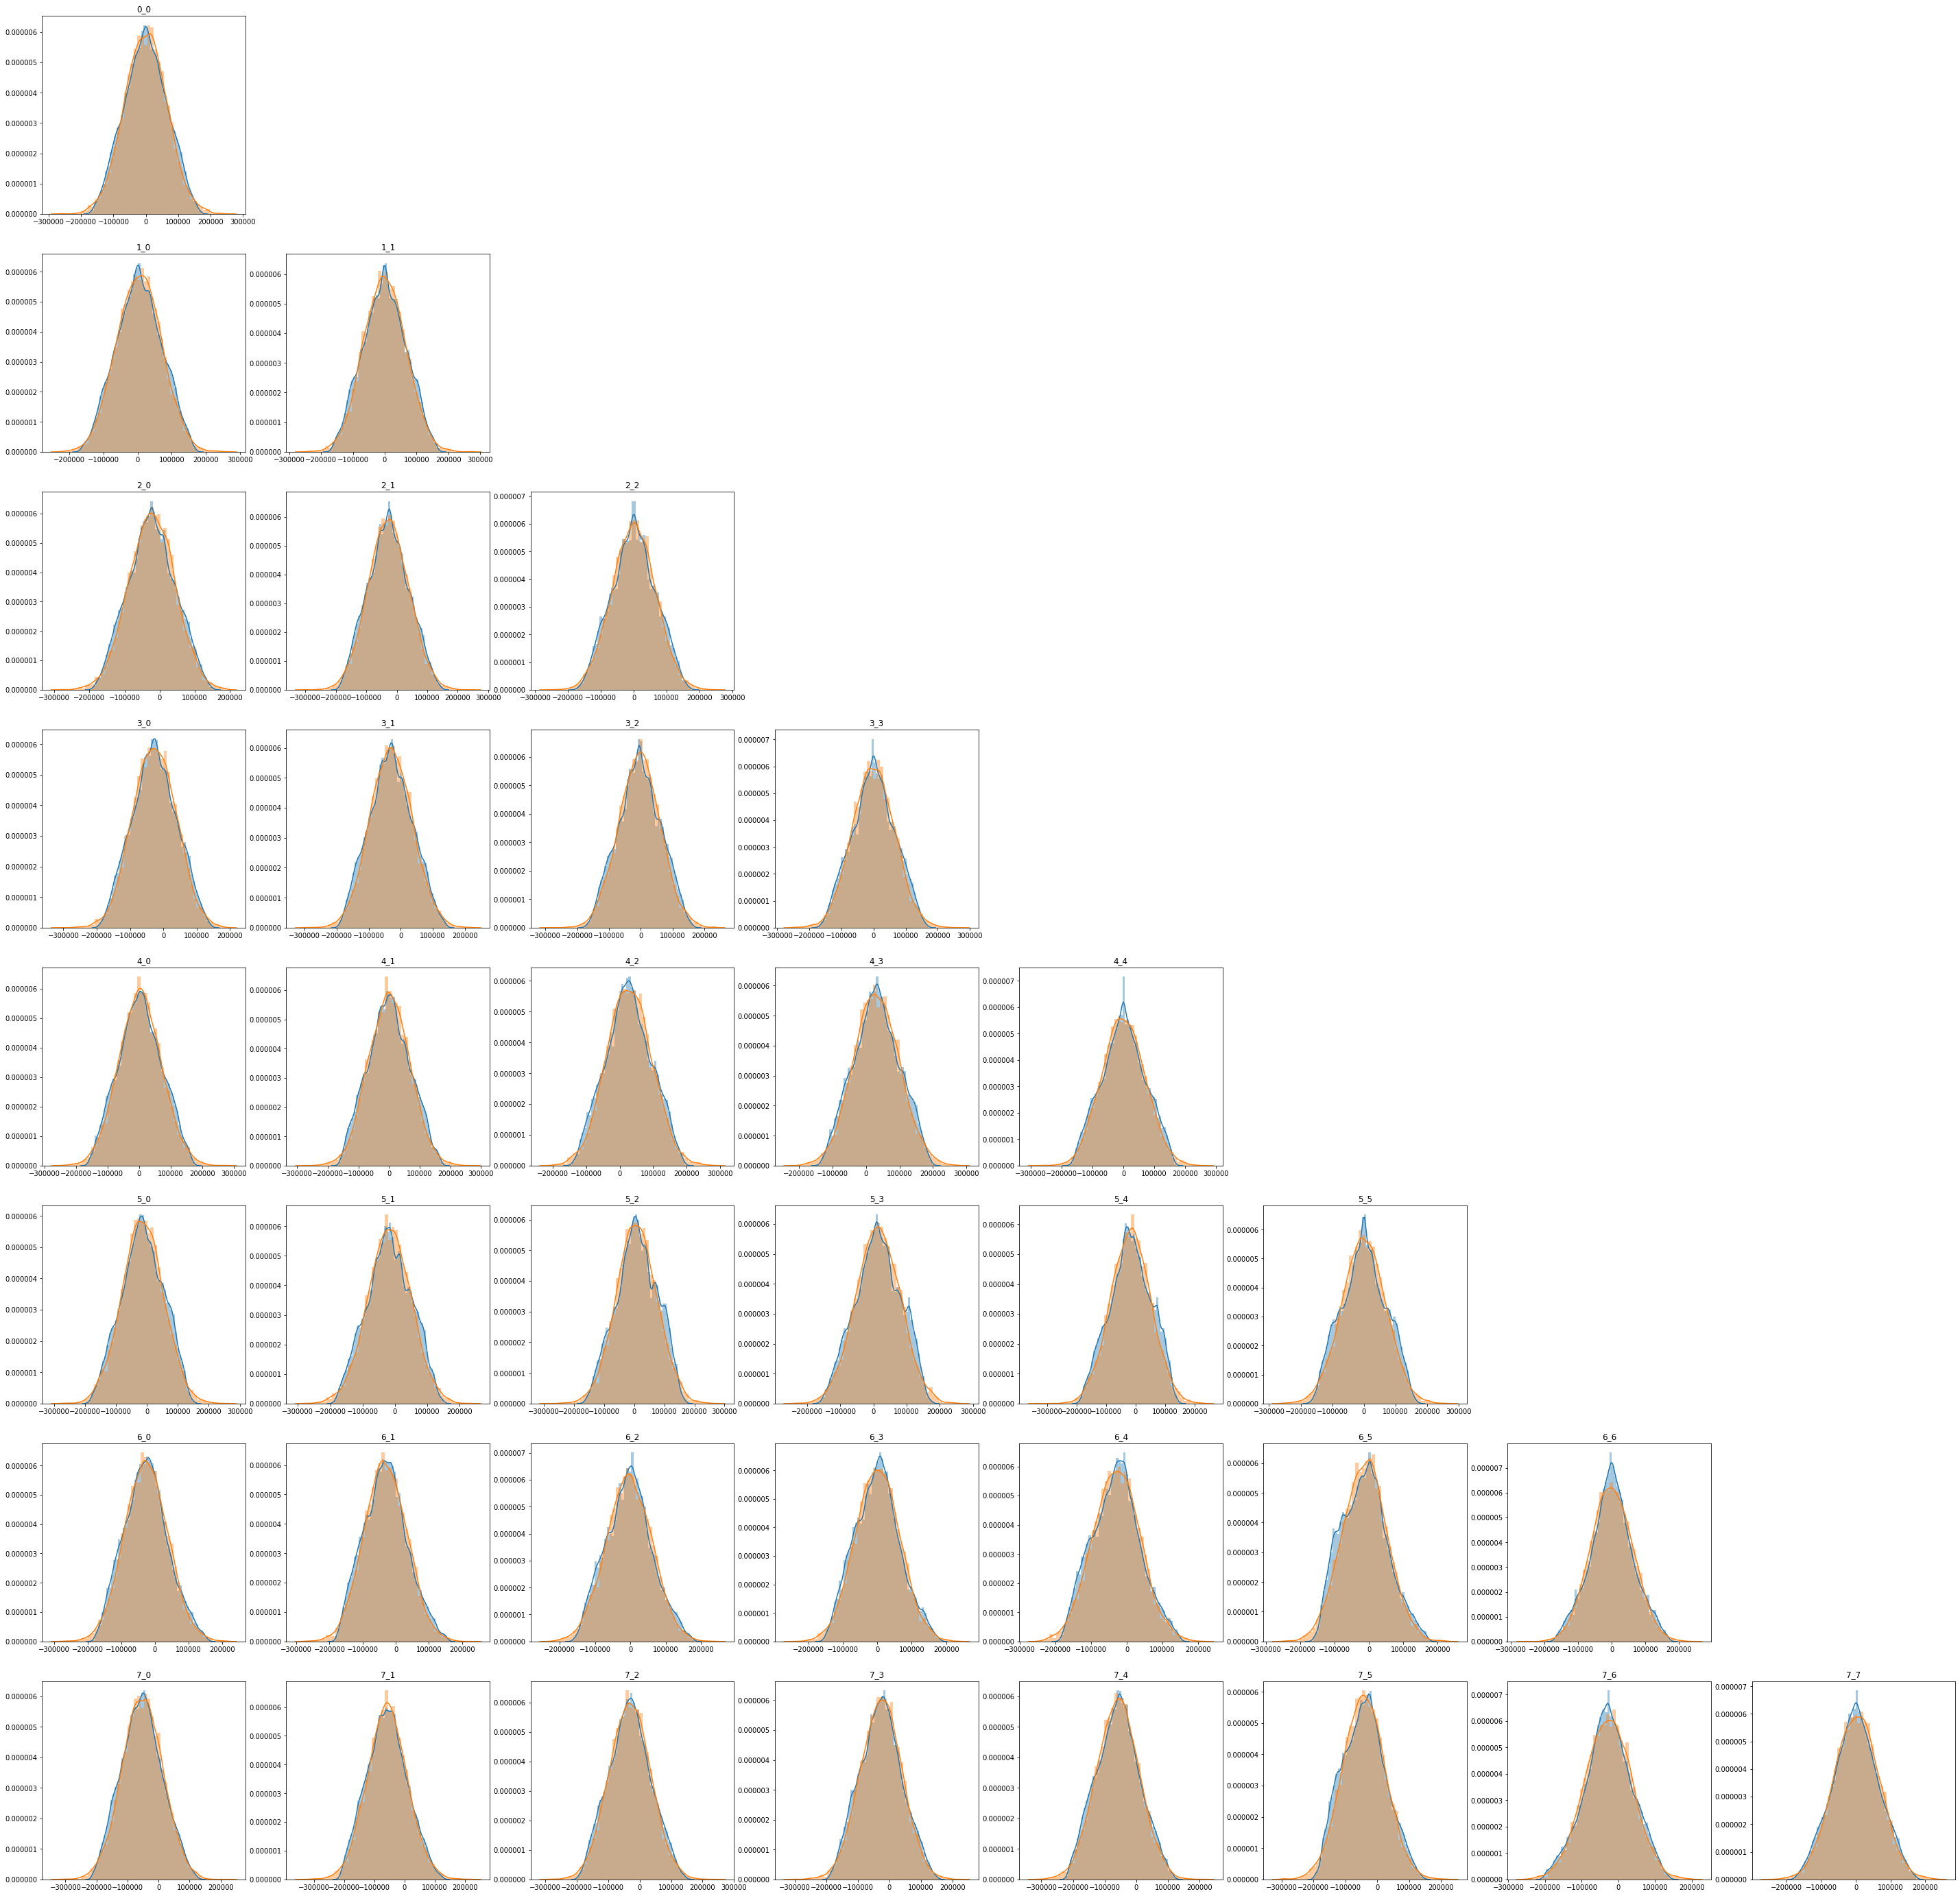

In [14]:
# def get_gmm3(i, j):
#     g1 = total.fits[i][j].toGaussianMixture()
#     vals1 = g1.sample(10000)[0]
#     return vals1

# plt.figure(figsize=(50,50))
# cam_num = st_model.cam_num
# for i in range(cam_num):
#     for j in range(i+1):
#         plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
#         # plot delta
#         d = get_gmm3(i, j)
#         sns.distplot(total.deltas[i][j])
#         sns.distplot(d)
#         plt.title('%d_%d' % (i, j))
# plt.show()

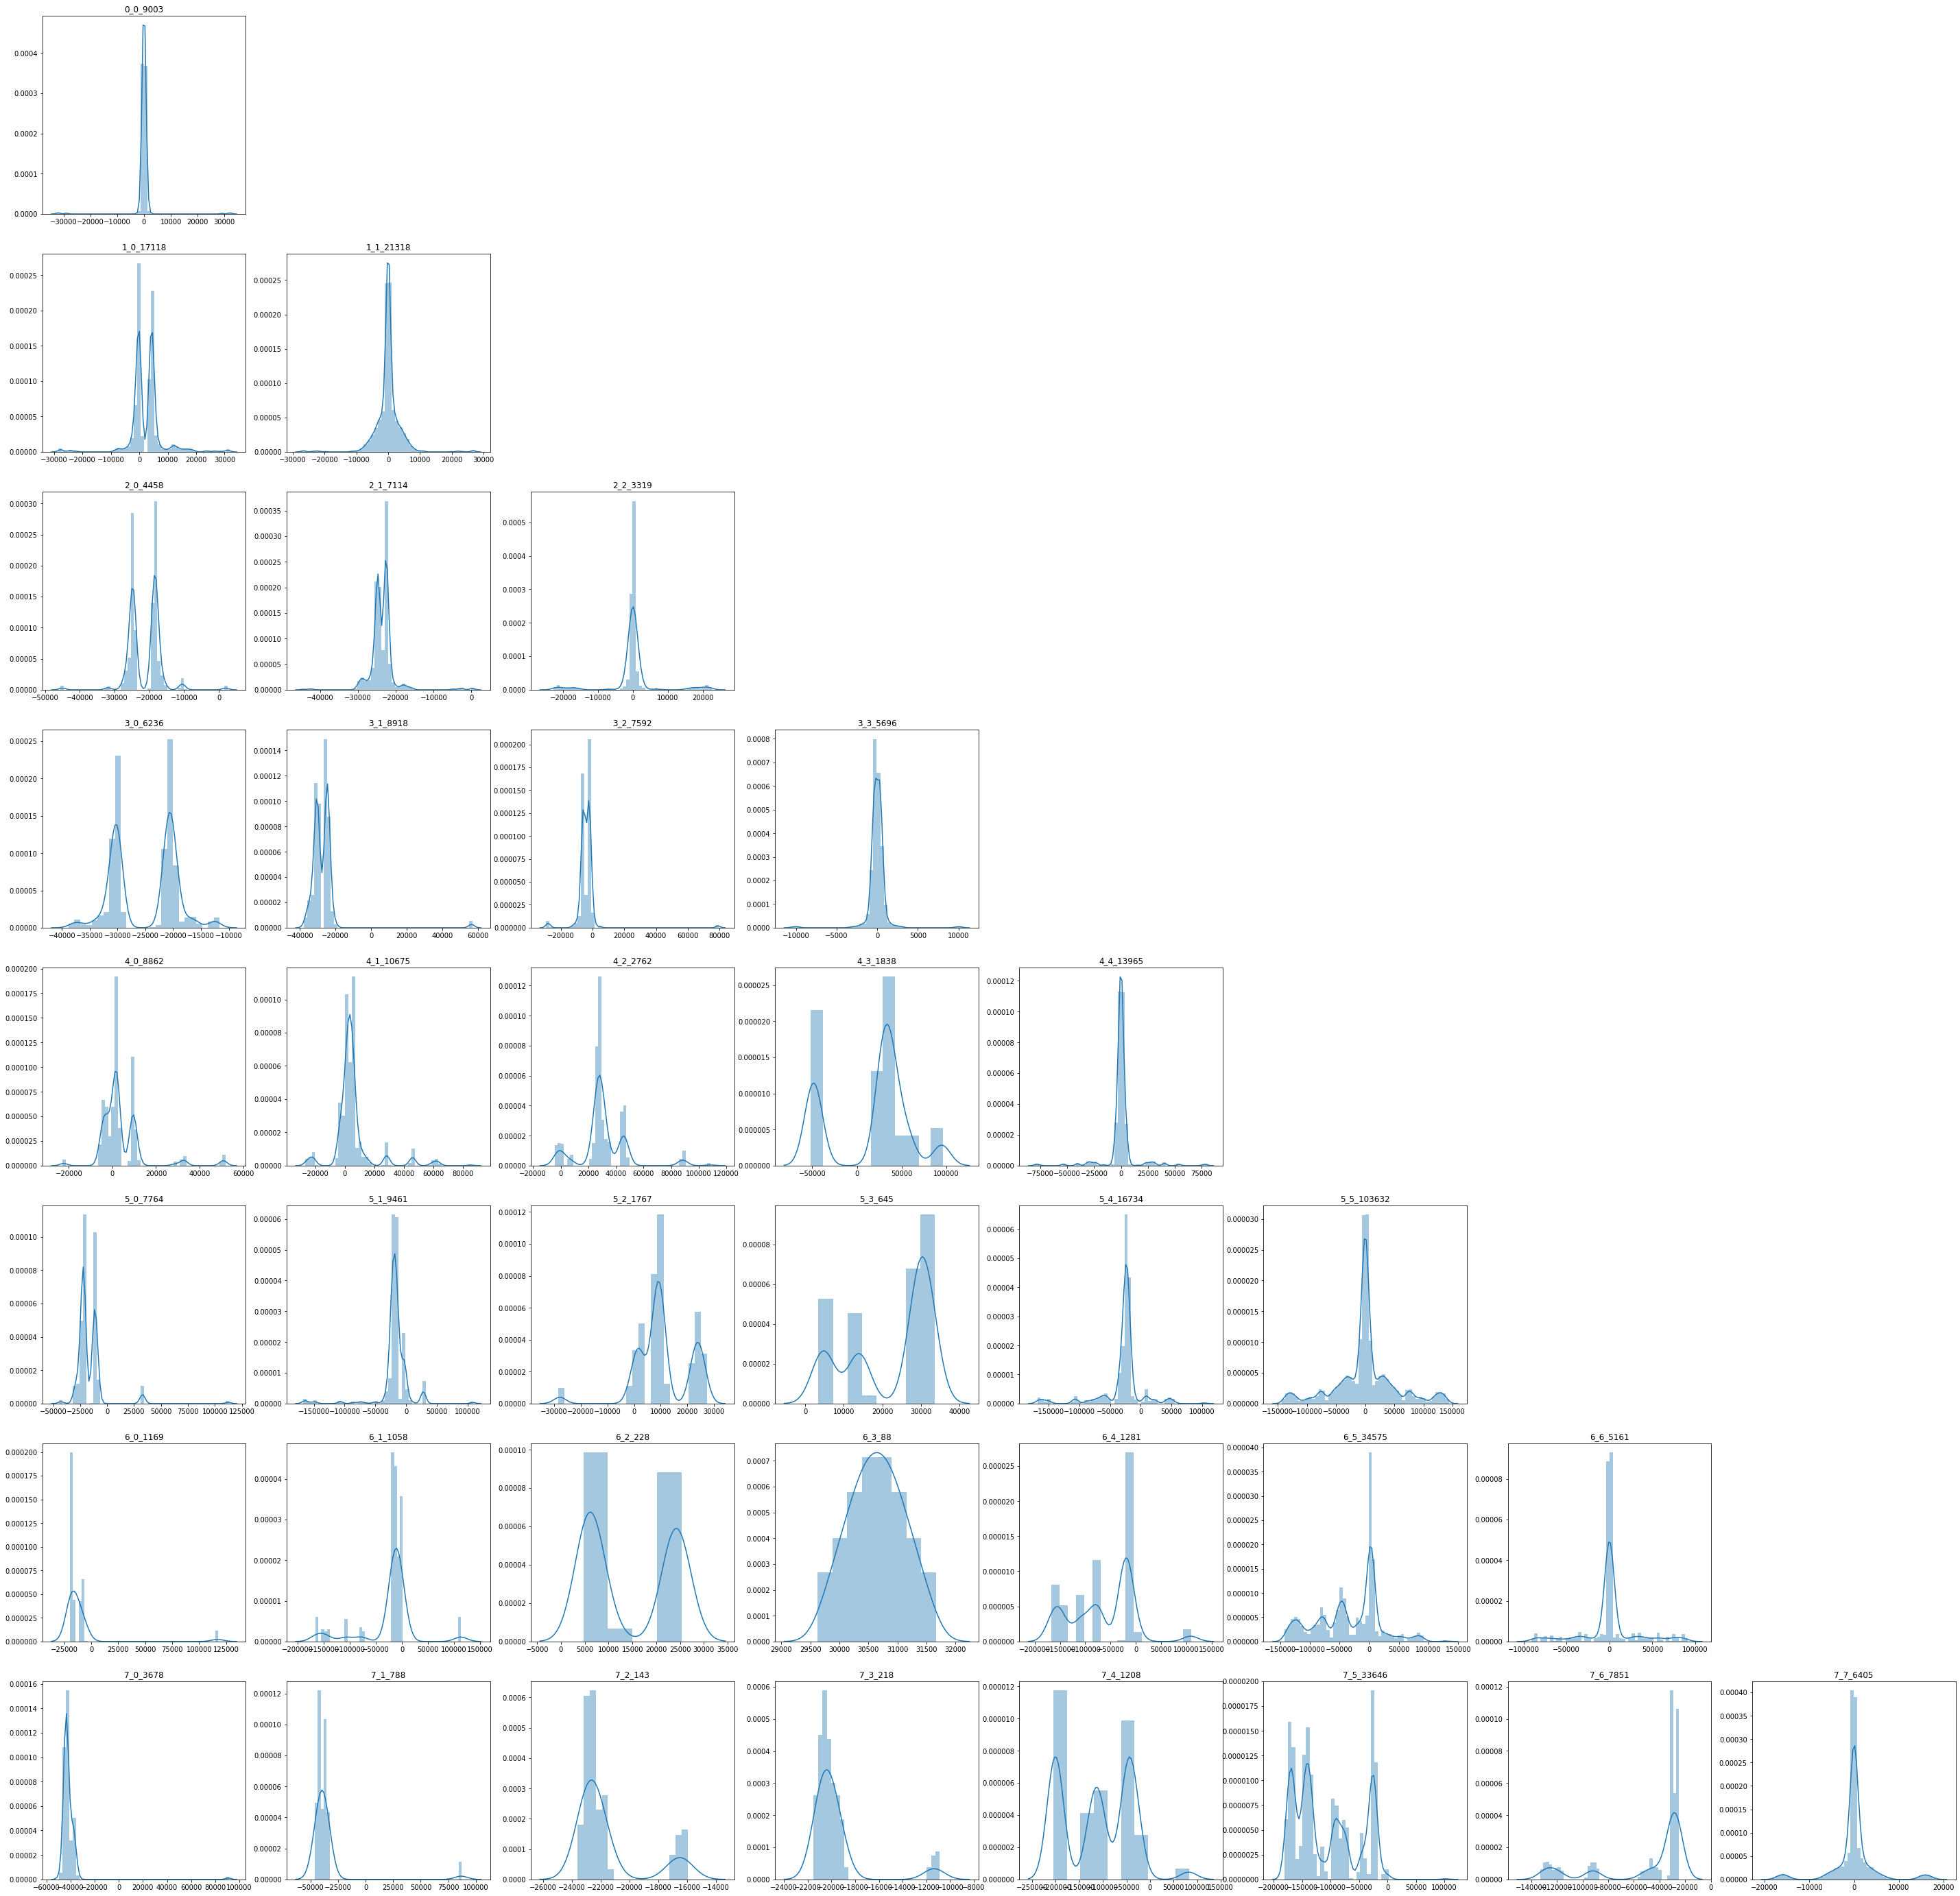

In [6]:
# plt.figure(figsize=(50,50))
# cam_num = st_model.cam_num
# for i in range(cam_num):
#     for j in range(i+1):
#         plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
#         # plot delta
#         sns.distplot(same.deltas[i][j])
#         plt.title('%d_%d_%d' % (i, j, len(same.deltas[i][j])))
# plt.show()

In [7]:
# print(len(tgt_dataset.trainval))

16522


In [15]:
# cam_num = st_model.cam_num
# for i in range(cam_num):
#     for j in range(i+1):
#         print('%5d %5d | ' % (len(same.deltas[i][j]), len(same2.deltas[i][j])), end='')
#     print('')

 9003  8982 | 
17118 11922 | 21318 13130 | 
 4458  3242 |  7114  5417 |  3319  2384 | 
 6236   550 |  8918  1135 |  7592  1083 |  5696  8316 | 
 8862  5334 | 10675  8295 |  2762  1248 |  1838   563 | 13965  9555 | 
 7764  5563 |  9461  6574 |  1767  1290 |   645   359 | 16734  8118 | 103632 21271 | 
 1169  1031 |  1058   902 |   228   332 |    88    41 |  1281   717 | 34575 13073 |  5161  4271 | 
 3678  3653 |   788  1283 |   143   425 |   218   323 |  1208   553 | 33646  5413 |  7851  3867 |  6405  4272 | 


In [10]:
# def test_gmm(i, j):
#     gmm = st_model.probs[i][j]
#     for i in range(gmm.n):
#         print('%f: %f' % (gmm.means[i], gmm.val(gmm.means[i])))

In [11]:
# test_gmm(2, 1)

-24787.461657: 0.175146
-2048.044131: 0.003641
-22538.139809: 0.651126
-43214.150107: 0.002564
-18176.366779: 0.011942


In [ ]:
# evaluator = Evaluator(model, print_freq=args.print_freq)
# s = evaluator.evaluate(test_loader, tgt_dataset.query, tgt_dataset.gallery, st_model)

in peak

In [15]:
from tqdm import tqdm

st_dist = np.zeros(distmat.shape)
for i, (_, _, c1, t1) in enumerate(tqdm(tgt_dataset.query)):
    for j, (_, _, c2, t2) in enumerate(tgt_dataset.gallery):
        if same2.in_peak(c1, c2, t1, t2, 0.2):
            st_dist[i, j] = -1
        
st_dist = torch.tensor(st_dist)

100%|██████████| 2228/2228 [03:06<00:00, 11.93it/s]


$p(z|ST,vis)=\frac{1}{p(z)(\frac{1}{p(z|ST)}-1)(\frac{1}{p(z|vis)}-1)}$

$d'=d+\alpha\ln{\frac{1}{p(z|ST)}}$

In [15]:
from tqdm import tqdm

def rate_ln(x, thres=1e-6):
    x_reverse = 1 / (x + thres)
    return np.log(max(0, x_reverse - 1) + thres)

st_dist = np.zeros(distmat.shape)
for i, (_, _, c1, t1) in enumerate(tqdm(tgt_dataset.query)):
    for j, (_, _, c2, t2) in enumerate(tgt_dataset.gallery):
        p = st_model2.val(c1, c2, t1, t2)
        st_dist[i, j] = rate_ln(p)
        
st_dist = torch.tensor(st_dist)

100%|██████████| 2228/2228 [26:27<00:00,  1.43it/s]


In [13]:
st_dist.mean(), st_dist.var()

(tensor(-0.2193, dtype=torch.float64), tensor(0.1712, dtype=torch.float64))

In [14]:
distmat.mean(), distmat.var()

(tensor(1.1475), tensor(0.0345))

In [21]:
st_dist.max()

tensor(13.8155, dtype=torch.float64)

In [22]:
# distmat.mean(), distmat.var()

(tensor(680.9680), tensor(21301.2422))

In [12]:
# print(distmat.mean() / (- ln(st_model.same_rate)))

tensor(115.0302)


In [15]:
from reid.evaluators import mean_ap

def evaluate_alpha(alphas=[0.1]):
    query_ids = [pid for _, pid, _, _ in tgt_dataset.query]
    gallery_ids = [pid for _, pid, _, _ in tgt_dataset.gallery]
    query_cams = [cam for _, _, cam, _ in tgt_dataset.query]
    gallery_cams = [cam for _, _, cam, _ in tgt_dataset.gallery]
    
    for alpha in alphas:
#         distmat_st = torch.pow(distmat, 2) + st_dist * alpha
        distmat_st = distmat + st_dist * alpha
#         distmat_st = torch.tensor(distmat2) + st_dist * alpha
        mAP = mean_ap(distmat_st, query_ids, gallery_ids, query_cams, gallery_cams)
        print(alpha, mAP)

using val(0.01) mean: 0.1826

In [18]:
evaluate_alpha([0, 200, 400, 600, 800, 1000])

0 0.48716750951317633
200 0.5843415789563292
400 0.5777757283215446
600 0.5769367280783722
800 0.5768562443468347
1000 0.5768522930079282


using in_peak(0.2) mean:0.1933

In [45]:
evaluate_alpha([0, 200, 400, 600, 800, 1000])

0 0.48716750951317633
200 0.6245267573020051
400 0.6197120338608375
600 0.6187314496700824
800 0.6186436773091482
1000 0.6186387760103679


In [16]:
evaluate_alpha([0, 0.2, 0.4, 0.6, 0.8, 1.0])

0 0.49362684492530984
0.2 0.6043253646454967
0.4 0.6064557898593315
0.6 0.603151750317446
0.8 0.6020206290652849
1.0 0.6017740586120552


using distmat2 reranked

In [49]:
evaluate_alpha([0, 0.2, 0.4, 0.6, 0.8, 1.0])

0 0.6279101844818367
0.2 0.7004753859448918
0.4 0.7075517090826894
0.6 0.7071578013042158
0.8 0.7058892199737052
1.0 0.7058888349879778


using my formula

In [24]:
evaluate_alpha(list(range(20)))

0 0.487167361582075
1 0.496859259413796
2 0.5057388857141846
3 0.5138804576894025
4 0.5214201815708791
5 0.5275028079459438
6 0.5327541396902442
7 0.5365879454408113
8 0.5388204179980913
9 0.5392720165039445
10 0.5377659613125155
11 0.5347238074140028
12 0.5293113436275669
13 0.5223364591921172
14 0.5146442458564694
15 0.5053631190645226
16 0.49531794439487686
17 0.48393822412751775
18 0.4713748720208638
19 0.4578171030342886


In [22]:
def get_cluster_from(dataset):
    cluster_by_pid = {}
    for (pid0, pid, cam, timestamp) in dataset:
        if pid not in cluster_by_pid:
            cluster_by_pid[pid] = []
        cluster_by_pid[pid].append((pid0, cam, timestamp))
    return cluster_by_pid

In [23]:
cluster_gt = get_cluster_from(tgt_dataset.trainval)

In [24]:
def get_gt_info(dataset):
    l0 = len(dataset)
    clusters = get_cluster_from(dataset)
    T, F = (0, 0)
    for cluster in clusters.values():
        l = len(cluster)
        T += l * (l - 1) / 2
    F = l0 * (l0 - 1) / 2 - T
    return T, F

T_gt, F_gt = get_gt_info(tgt_dataset.trainval)

In [25]:
cluster_by_pid = get_cluster_from(new_dataset)

In [26]:
T_cluster, F_cluster = get_gt_info(new_dataset)
print(T_gt, T_cluster, F_gt, F_cluster)

366374.0 166257.0 136113607.0 127505953.0


In [27]:
def count_values(f):
    SP, SF = (0, 0)
    
    for cluster in cluster_by_pid.values():
        l = len(cluster)
        for i in range(l):
            for j in range(i):
                if not f(cluster[i][1], cluster[j][1], cluster[i][2], cluster[j][2]):
                    continue
                if cluster[i][0] == cluster[j][0]:
                    SP += 1
                else:
                    SF += 1
        
    return SP, SF

def print_values(f):
    SP, SF = count_values(f)
    print('matched false rate: %.3f' % (1 - SP / (SP + SF)))
    print('matched true num: %d' % SP)
    print('inmatched true num: %d' % (T_gt - SP))
    return SP

In [28]:
def all_pass(c1, c2, t1, t2):
    return True

def all_fail(c1, c2, t1, t2):
    return False

SP_0 = print_values(all_pass)

matched false rate: 0.142
matched true num: 142723
inmatched true num: 223651


In [33]:
def expr(f):
    SP, SF = count_values(f)
    print('preci:  %.3f' % (SP / (SP + SF)))
    print('recall: %.3f' % (SP / T_gt))
    
expr(all_pass)

preci:  0.765
recall: 0.343


In [29]:
def in_delta(same):
    if not same: return all_pass
    return same.in_delta

def on_peak(same, alpha):
    if not same: return all_pass
    def f(c1, c2, t1, t2):
        return same.in_peak(c1, c2, t1, t2, alpha)
    return f

def val(same, alpha):
    if not same: return all_pass
    def f(c1, c2, t1, t2):
        return same.val(c1, c2, t1, t2) > alpha
    return f

In [35]:
def expr_(f, s, alphas):
    SP0, SF0 = count_values(all_pass)
    for alpha in alphas:
        SP, SF = count_values(f(s, alpha))
        a1 = SP / SP0
        a2 = SF / SF0
        print(a1, a2)

In [36]:
expr_(val, st_model2, [0.005, 0.01, 0.02])

0.9786535434322876 0.6691641906730397
0.9527992876564214 0.5738535072987986
0.8961536626862349 0.39201653533135256


In [38]:
expr_(on_peak, same2, [0.05, 0.1, 0.15, 0.2])

0.9916522236886041 0.9035525125952719
0.9624986087039481 0.721121302157344
0.8940547932136553 0.5347371140679499
0.8857070169022595 0.2976359643456918


In [30]:
expr(in_delta(same))

preci:  0.984
recall: 0.342


In [31]:
expr(in_delta(same2))

preci:  0.785
recall: 0.341


In [32]:
expr(on_peak(same, 0.1))

preci:  0.880
recall: 0.332


In [33]:
expr(on_peak(same2, 0.1))

preci:  0.814
recall: 0.329


In [25]:
expr(on_peak(same2, 0.15))

preci:  0.837
recall: 0.316


In [34]:
expr(val(st_model, 0.005))

preci:  0.883
recall: 0.336


In [35]:
expr(val(st_model2, 0.005))

preci:  0.826
recall: 0.336


In [36]:
expr(val(same, 0.02))

preci:  0.885
recall: 0.335


In [37]:
expr(val(same2, 0.01))

preci:  0.839
recall: 0.334


In [38]:
expr(on_peak(st_model2, 0.1))

preci:  0.802
recall: 0.316


In [39]:
expr(val(st_model2, 0.01))

preci:  0.845
recall: 0.327


In [40]:
expr(val(st_model2, 0.02))

preci:  0.882
recall: 0.307


In [64]:
len(tgt_dataset.trainval), len(new_dataset)

(16522, 13778)

In [67]:
len(cluster_by_pid), len(cluster_gt)

(664, 702)

In [68]:
len(tgt_dataset.trainval) / len(cluster_gt)

23.535612535612536

In [69]:
len(new_dataset) / len(cluster_by_pid)

20.75

In [30]:
cluster_size = int(len(tgt_dataset.trainval) / len(cluster_gt))

## Test MMT result

In [41]:
mmt = np.load('../MMT/mmt.npy')
mmt_gt = np.load('../MMT/mmt_gt.npy')

In [42]:
def get_cluster_from_mmt():
    cluster_by_pid = {}
    for i in range(len(mmt)):
        pid = mmt[i]
        if pid not in cluster_by_pid:
            cluster_by_pid[pid] = []
        cluster_by_pid[pid].append(i)
    return cluster_by_pid

cluster_mmt = get_cluster_from_mmt()

In [43]:
def count_mmt():
    SP, SF = (0, 0)
    
    for cluster in cluster_mmt.values():
        l = len(cluster)
        for i in range(l):
            for j in range(i):
                if mmt_gt[cluster[i]] == mmt_gt[cluster[j]]:
                    SP += 1
                else:
                    SF += 1
        
    return SP, SF

def print_mmt():
    SP, SF = count_mmt()
    print('preci:  %.3f' % (SP / (SP + SF)))
    print('recall: %.3f' % (SP / T_gt))
    return SP

In [44]:
T_mmt = print_mmt()

preci:  0.751
recall: 0.458


## k-nn

In [31]:
ranking = np.argsort(rerank_dist)[:,1:]

In [37]:
def count_knn(f, k):
    SP, SF = (0, 0)
    
    dataset = tgt_dataset.trainval
    length = len(dataset)
    for i in range(length):
        for j_ in range(k):
            j = ranking[i][j_]
            if f(i, j, k):
                if dataset[i][1] == dataset[j][1]:
                    SP += 1
                else:
                    SF += 1
        
    return SP, SF

def print_knn(f, k):
    SP, SF = count_knn(f, k)
    print('preci:  %.3f' % (SP / (SP + SF)))
    print('recall: %.3f' % (SP / T_gt))
    return SP

In [32]:
def intersect(i, j, k):
    if j not in ranking[i][:k]:
        return False
    if i not in ranking[j][:k]:
        return False
    return True

def union(i, j, k):
    if j in ranking[i][:k]:
        return True
    if i in ranking[j][:k]:
        return True
    return False

In [49]:
print_knn(intersect, 15)

preci:  0.850
recall: 0.427


156443

In [50]:
print_knn(union, 15)

preci:  0.777
recall: 0.525


192523

In [51]:
print_knn(intersect, 20)

preci:  0.791
recall: 0.551


201771

In [52]:
print_knn(union, 20)

preci:  0.701
recall: 0.632


231589

In [53]:
print_knn(intersect, 25)

preci:  0.728
recall: 0.639


234225

In [54]:
print_knn(union, 25)

preci:  0.626
recall: 0.706


258642

In [41]:
print_knn(intersect, cluster_size - 1)

preci:  0.765
recall: 0.590


216201

In [32]:
def count_kth(f, k):
    SP, SF = (0, 0)
    
    dataset = tgt_dataset.trainval
    length = len(dataset)
    for i in range(length):
        j = ranking[i][k-1]
        if f(i, j, k):
            if dataset[i][1] == dataset[j][1]:
                SP += 1
            else:
                SF += 1
        
    return SP, SF

def print_kth(f, a, b):
    for k in range(a, b):
        SP, SF = count_kth(f, k)
        print('%d: %.3f' % (k, 1 - SP / (SP + SF)))

In [81]:
print_kth(intersect, 5, 30)

5: 0.078
6: 0.082
7: 0.087
8: 0.093
9: 0.100
10: 0.108
11: 0.115
12: 0.123
13: 0.132
14: 0.141
15: 0.150
16: 0.160
17: 0.171
18: 0.183
19: 0.196
20: 0.209
21: 0.222
22: 0.235
23: 0.248
24: 0.260
25: 0.272
26: 0.284
27: 0.296
28: 0.307
29: 0.318


In [33]:
def count_kth_st(f, k):
    SP, SF = (0, 0)
    g = val(st_model2, 0.005)
    
    dataset = tgt_dataset.trainval
    length = len(dataset)
    for i in range(length):
        j = ranking[i][k-1]
        if f(i, j, k) and g(dataset[i][2], dataset[j][2], dataset[i][3], dataset[j][3]):
            if dataset[i][1] == dataset[j][1]:
                SP += 1
            else:
                SF += 1
        
    return SP, SF

def print_kth_st(f, a, b):
    for k in range(a, b):
        SP, SF = count_kth(f, k)
        SP2, SF2 = count_kth_st(f, k)
        print('%2d: %.3f %.3f' % (k, 1 - SP / (SP + SF), 1 - SP2 / (SP2 + SF2)))

In [34]:
print_kth_st(intersect, 5, 40)

 5: 0.091 0.073
 6: 0.098 0.079
 7: 0.116 0.095
 8: 0.132 0.107
 9: 0.154 0.127
10: 0.169 0.132
11: 0.175 0.135
12: 0.198 0.159
13: 0.219 0.172
14: 0.237 0.182
15: 0.259 0.194
16: 0.290 0.200
17: 0.325 0.229
18: 0.366 0.259
19: 0.418 0.292
20: 0.439 0.309
21: 0.469 0.346
22: 0.481 0.344
23: 0.522 0.375
24: 0.535 0.388
25: 0.579 0.411
26: 0.609 0.454
27: 0.618 0.454
28: 0.649 0.485
29: 0.660 0.508
30: 0.678 0.521
31: 0.683 0.520
32: 0.692 0.547
33: 0.694 0.541
34: 0.677 0.522
35: 0.691 0.526
36: 0.699 0.549
37: 0.709 0.557
38: 0.731 0.593
39: 0.714 0.579


In [34]:
def two_stage(a, b, f):
    dataset = tgt_dataset.trainval
    
    def g(i, j):
        if intersect(i, j, a):
            return True
        if intersect(i, j, b) and f(dataset[i][2], dataset[j][2], dataset[i][3], dataset[j][3]):
            return True
        return False
    
    return g

def count_two_stage(a, b, f):
    SP, SF, DP, DF = (0, 0, 0, 0)
    g = two_stage(a, b, f)
    
    dataset = tgt_dataset.trainval
    length = len(dataset)
    for i in range(length):
        for j_ in range(b):
            j = ranking[i][j_]
            S = g(i, j)
            P = dataset[i][1] == dataset[j][1]
            if S:
                if P:
                    SP += 1
                else:
                    SF += 1
            else:
                if P:
                    DP += 1
                else:
                    DF += 1
        
    return SP, SF, DP, DF

def print_two_stage(a, b, f):
    SP, SF, DP, DF = count_two_stage(a, b, f)
    print('1 preci:  %.3f' % (SP / (SP + SF)))
    print('1 recall: %.3f' % (SP / T_gt))
    print('0 preci:  %.3f' % (DF / (DP + DF)))

In [26]:
print_two_stage(15, 25, val(st_model2, 0.01))

preci:  0.812
recall: 0.626


In [27]:
print_two_stage(15, 25, val(st_model2, 0.005))

preci:  0.792
recall: 0.633


In [28]:
print_two_stage(20, 30, val(st_model2, 0.01))

preci:  0.755
recall: 0.681


In [29]:
print_two_stage(20, 30, val(st_model2, 0.005))

preci:  0.738
recall: 0.689


In [35]:
print_two_stage(20, 40, val(st_model2, 0.01))

preci:  0.723
recall: 0.746


In [36]:
print_two_stage(20, 40, val(st_model2, 0.005))

preci:  0.696
recall: 0.760


In [42]:
print_two_stage(cluster_size - 5, cluster_size + 10, val(st_model2, 0.01))

preci:  0.758
recall: 0.701


In [32]:
print_two_stage(int(cluster_size * 1), int(cluster_size * 2), all_fail)

1 preci:  0.752
1 recall: 0.608
0 preci:  0.807


In [31]:
print_two_stage(int(cluster_size * 0.5), int(cluster_size * 1.5), all_fail)

1 preci:  0.885
1 recall: 0.306
0 preci:  0.595


In [28]:
print_two_stage(int(cluster_size * 0.5), int(cluster_size * 1.5), val(st_model2, 0.01))

1 preci:  0.772
1 recall: 0.701
0 preci:  0.863


In [33]:
print_two_stage(int(cluster_size * 0.5), int(cluster_size * 2), val(st_model2, 0.01))

1 preci:  0.727
1 recall: 0.763
0 preci:  0.913


In [29]:
print_two_stage(int(cluster_size * 0.5), int(cluster_size * 1.5), on_peak(same2, 0.2))

1 preci:  0.843
1 recall: 0.687
0 preci:  0.861


In [35]:
print_two_stage(int(cluster_size * 0.5), int(cluster_size * 2), on_peak(same2, 0.2))

1 preci:  0.881
1 recall: 0.767
0 preci:  0.942


In [36]:
def plot_two_stage(a, b, f):
    g = two_stage(a, b, f)
    dist_p, dist_n = [], []
    
    dataset = tgt_dataset.trainval
    length = len(dataset)
    for i in range(length):
        for j_ in range(b):
            j = ranking[i][j_]
            if g(i, j):
                dist_p.append(original_dist[i][j])
            else:
                dist_n.append(original_dist[i][j])
        
    plt.figure()
    sns.distplot(dist_p)
    sns.distplot(dist_n)

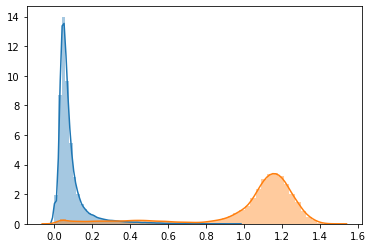

In [37]:
plot_two_stage(int(cluster_size * 0.5), int(cluster_size * 2), on_peak(same2, 0.2))

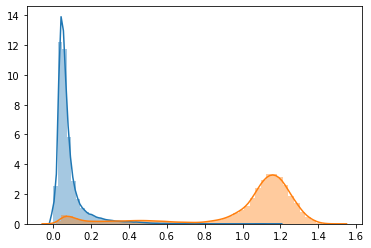

In [38]:
def plot_two_stage_(a, b, f):
    g = two_stage(a, b, f)
    dist_p, dist_n = [], []
    
    dataset = tgt_dataset.trainval
    length = len(dataset)
    for i in range(length):
        for j_ in range(b):
            j = ranking[i][j_]
            if dataset[i][1] == dataset[j][1]:
                dist_p.append(original_dist[i][j])
            else:
                dist_n.append(original_dist[i][j])
        
    plt.figure()
    sns.distplot(dist_p)
    sns.distplot(dist_n)

plot_two_stage_(int(cluster_size * 0.5), int(cluster_size * 2), on_peak(same2, 0.2))

In [66]:
from reid.st_model import ST_Model_KNN

st_model3 = ST_Model_KNN(tgt_dataset.meta['num_cameras'], ranking)

In [67]:
def filter1(i, j):
    return intersect(i, j, cluster_size - 1)

_, _ = st_model3.fit(tgt_dataset.trainval, filter1, cluster_size - 1)

In [68]:
print_two_stage(int(cluster_size * 0.5), int(cluster_size * 2), val(st_model3, 0.01))

preci:  0.734
recall: 0.731


In [69]:
def filter2(i, j):
    f = val(st_model3, 0.01)
    dataset = tgt_dataset.trainval
    if intersect(i, j, int(cluster_size * 0.5)):
        return True
    if intersect(i, j, int(cluster_size * 1.5)) and f(dataset[i][2], dataset[j][2], dataset[i][3], dataset[j][3]):
        return True
    return False

In [70]:
for i in range(5):
    st_model4 = ST_Model_KNN(tgt_dataset.meta['num_cameras'], ranking)
    _, _ = st_model4.fit(tgt_dataset.trainval, filter2, cluster_size - 1)
    st_model3 = st_model4
    print(i, ':')
    print_two_stage(int(cluster_size * 0.5), int(cluster_size * 2), val(st_model3, 0.01))

0 :
preci:  0.736
recall: 0.720
1 :
preci:  0.723
recall: 0.724
2 :
preci:  0.734
recall: 0.716
3 :
preci:  0.738
recall: 0.715
4 :
preci:  0.742
recall: 0.713


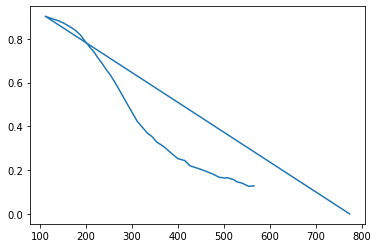

In [15]:
def draw_kth(dist, b):
    xs, ys = [], []
    for k in range(b):
        SP, SF = 0, 0
        distance = 0
        
        dataset = tgt_dataset.trainval
        length = len(dataset)
        for i in range(length):
            j = ranking[i][k-1]
            if dataset[i][1] == dataset[j][1]:
                SP += 1
            else:
                SF += 1
            distance += dist[i][j]
        distance = distance / length
        xs.append(distance)
        ys.append(SP / (SP + SF))
    plt.plot(xs, ys)
    plt.show()
    
draw_kth(original_dist, 40)

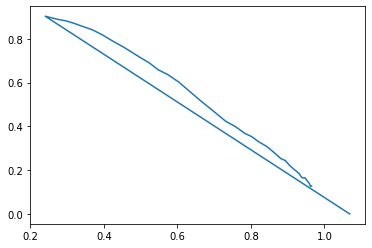

In [11]:
draw_kth(rerank_dist, 40)

## recover test set st distribution

In [40]:
from reid.st_model import Distribution

test_total = Distribution(tgt_dataset.meta['num_cameras'], 1)

for i, (_, _, c1, t1) in enumerate(tqdm(tgt_dataset.query)):
    for j, (_, _, c2, t2) in enumerate(tgt_dataset.gallery):
        test_total.update(c1, c2, t1, t2)

100%|██████████| 2228/2228 [00:37<00:00, 59.92it/s]


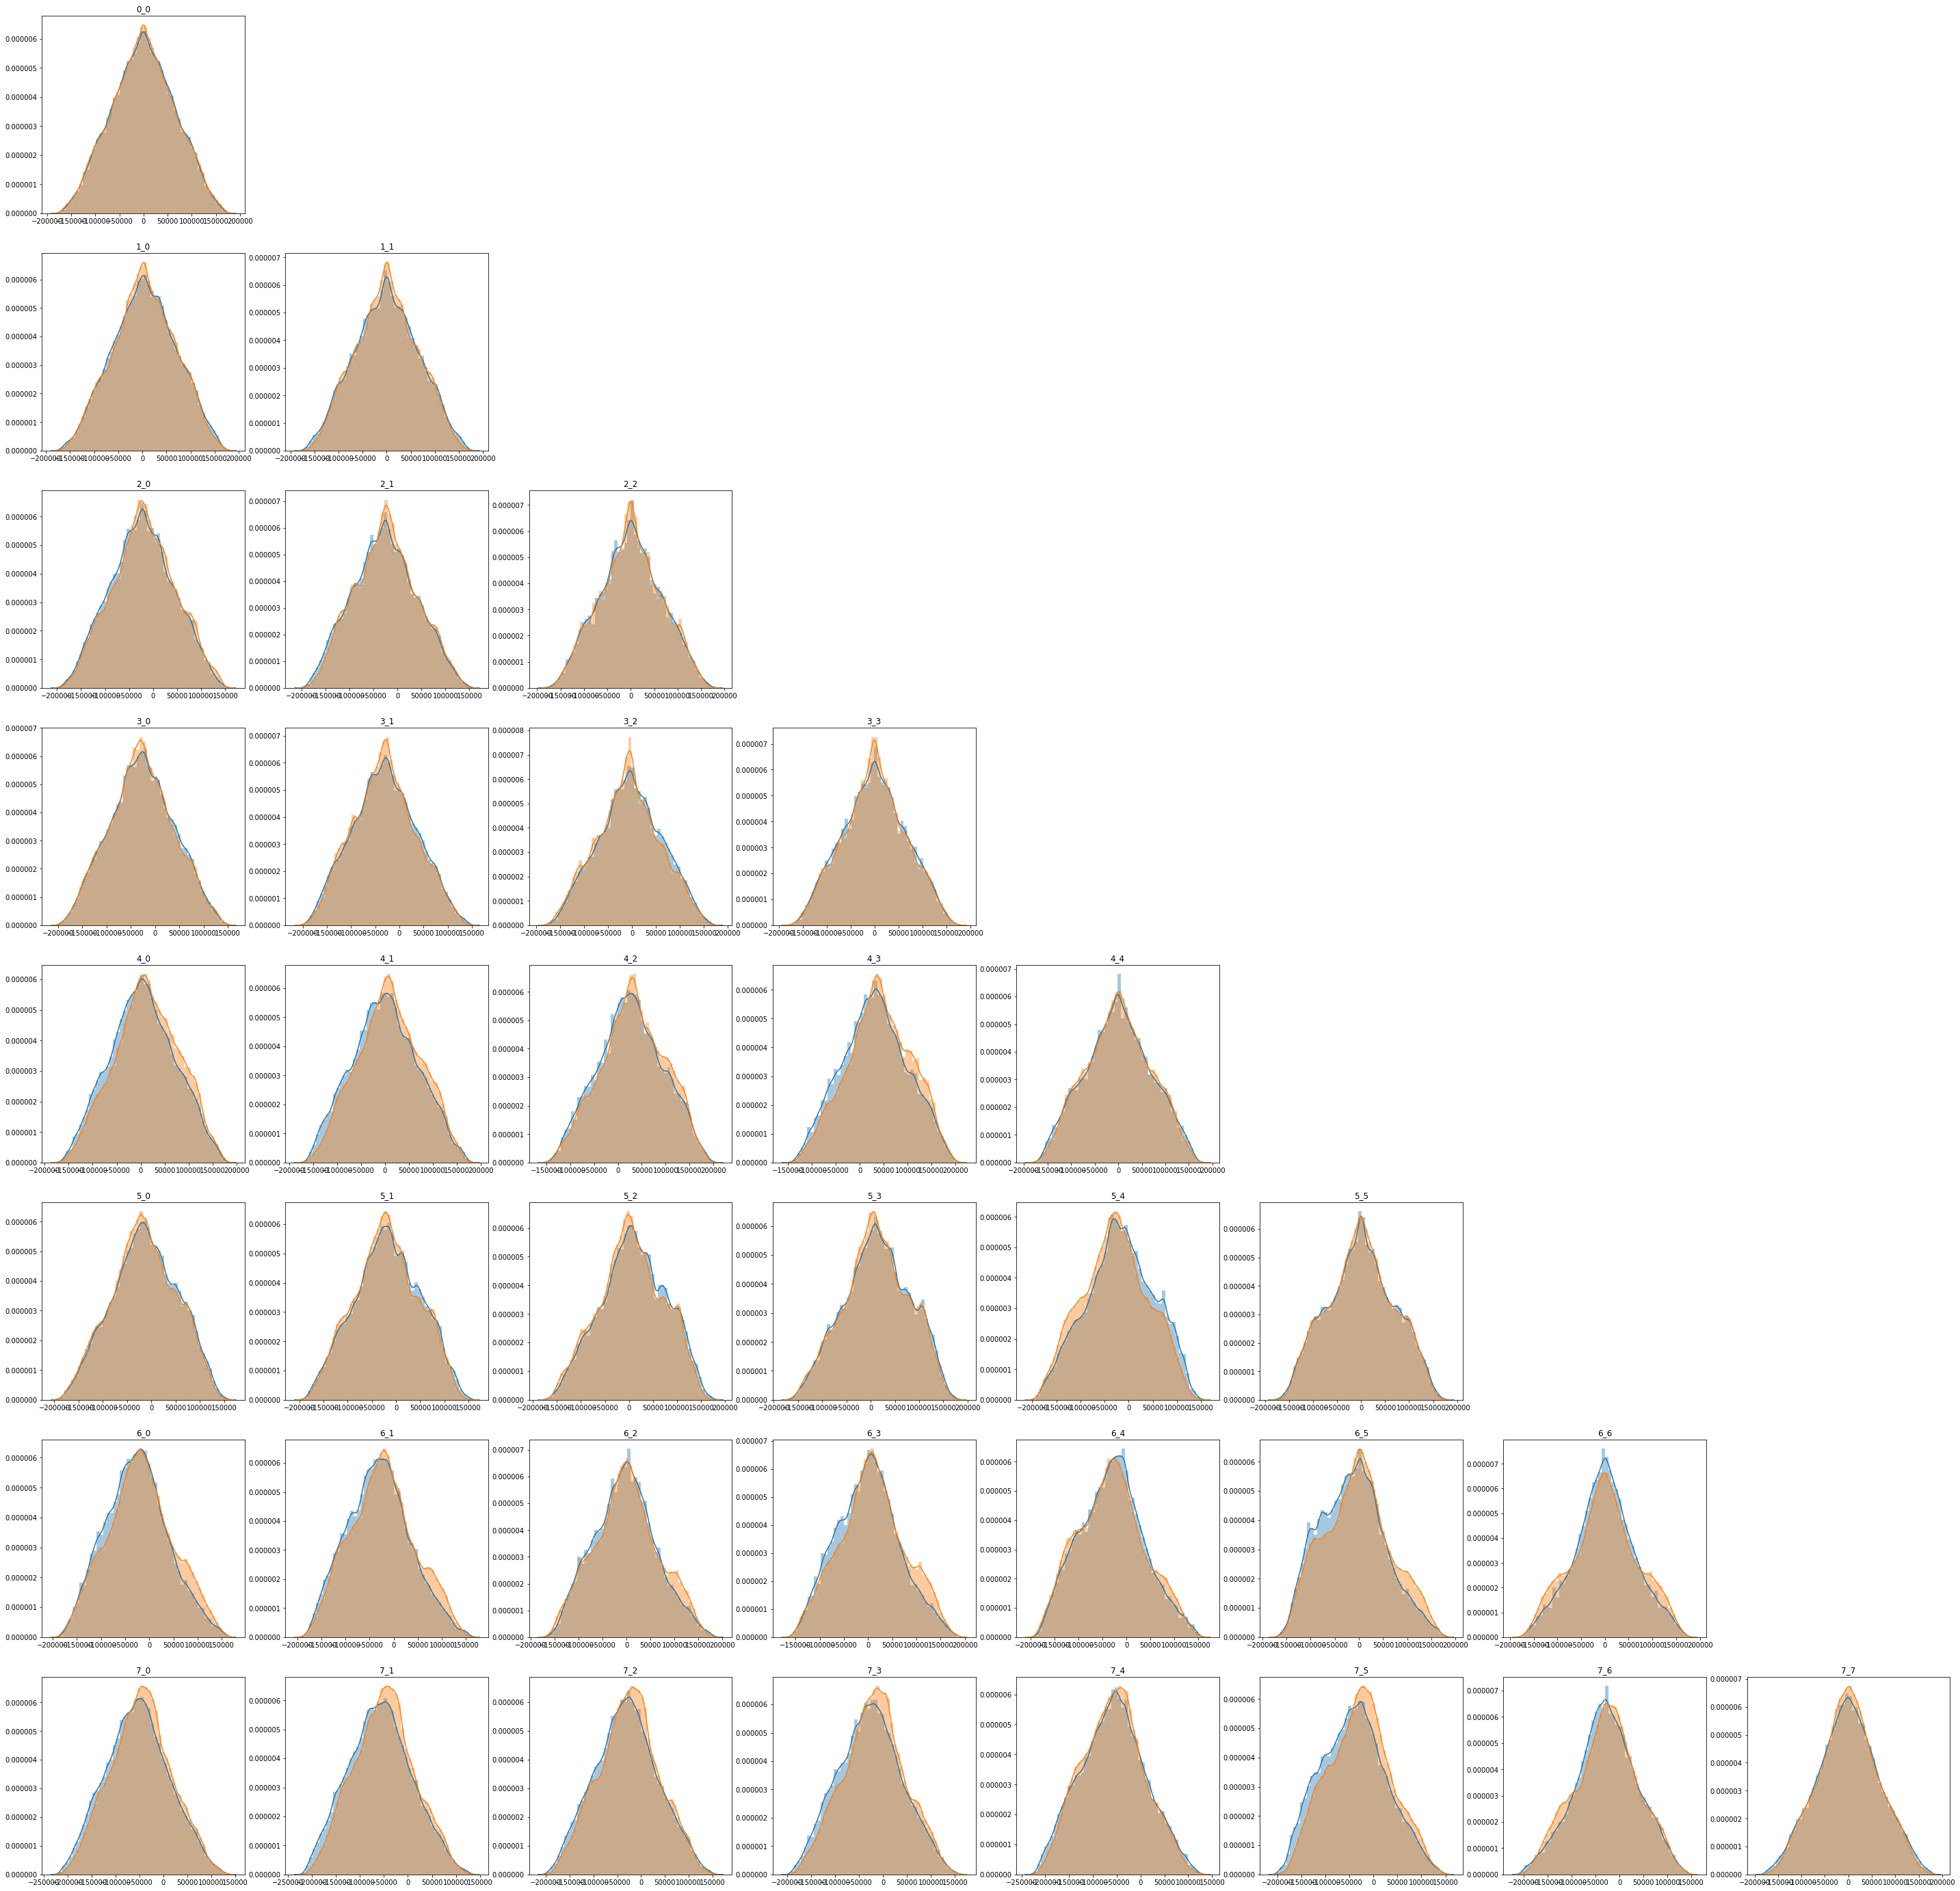

In [41]:
plt.figure(figsize=(50,50))
cam_num = st_model.cam_num
for i in range(cam_num):
    for j in range(i+1):
        plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
        sns.distplot(total.deltas[i][j])
        sns.distplot(test_total.deltas[i][j])
        plt.title('%d_%d' % (i, j))
plt.show()

In [ ]:
plt.figure(figsize=(50,50))
cam_num = st_model.cam_num
for i in range(cam_num):
    for j in range(i+1):
        plt.subplot(cam_num, cam_num, i * cam_num + j + 1)
        sns.distplot(same.deltas[i][j])
        sns.distplot(test_total.deltas[i][j])
        plt.title('%d_%d' % (i, j))
plt.show()

## recover scene

In [23]:
def filter(i, j):
    _, _, c1, t1 = tgt_dataset.trainval[i]
    _, _, c2, t2 = tgt_dataset.trainval[j]
    return same2.in_peak(c1, c2, t1, t2, 0.2)

must_conn = int(cluster_size / 2)
might_conn = int(cluster_size * 2)

length = len(tgt_dataset.trainval)
pos = [[] for _ in range(length)]
neg = [[] for _ in range(length)]
for i in range(length):
    for j_ in range(might_conn):
        j = ranking[i][j_]
        if j_ < must_conn and i in ranking[j][:must_conn]:
            pos[i].append(j)
        elif i in ranking[j][:might_conn] and filter(i, j):
            pos[i].append(j)
        # if j_ < must_conn or filter(i, j):
        #     pos[i].append(j)
        else:
            neg[i].append(j)
            
train_loader = DataLoader(
    Preprocessor(tgt_dataset.trainval, root=tgt_dataset.images_dir, transform=train_transformer),
    batch_size=args.batch_size, num_workers=4,
    # sampler=RandomIdentitySampler(new_dataset, args.num_instances),
    # shuffle=True,
    sampler=TripletSampler(tgt_dataset.trainval, pos, neg),
    pin_memory=True, drop_last=True
)

In [26]:
for inputs in train_loader:
    imgs, _, pids, _, _ = inputs
    print(pids)
    break

tensor([111, 111, 647, 374, 374, 179, 157, 157,  73, 691, 691, 692, 484, 437,
        324, 638, 638, 375, 311, 311, 350,  43,  43, 644, 379, 379, 647, 264,
        264, 647, 506, 506, 267, 629, 629, 375, 213, 213, 647, 177, 177, 647,
        593, 559, 452, 391, 391, 391, 662, 662, 231, 235, 235, 354, 637, 637,
        595, 399, 399, 647, 577, 577, 469, 654])


In [20]:
from reid.evaluators import mean_ap

def evaluate_alpha(alphas=[0.1]):
    query_ids = [pid for _, pid, _, _ in tgt_dataset.query]
    gallery_ids = [pid for _, pid, _, _ in tgt_dataset.gallery]
    query_cams = [cam for _, _, cam, _ in tgt_dataset.query]
    gallery_cams = [cam for _, _, cam, _ in tgt_dataset.gallery]
    
    for alpha in alphas:
#         distmat_st = torch.pow(distmat, 2) + st_dist * alpha
        distmat_st = distmat + st_dist * alpha
#         distmat_st = torch.tensor(distmat2) + st_dist * alpha
        mAP = mean_ap(distmat_st, query_ids, gallery_ids, query_cams, gallery_cams)
        print(alpha, mAP)

In [17]:
evaluate_alpha([0, 0.2, 0.4, 0.6, 0.8, 1.0])

0 0.6054477660664972
0.2 0.7535960829788166
0.4 0.7714615614976904
0.6 0.7648179173958896
0.8 0.7605051301609677
1.0 0.759653138457474


In [21]:
evaluate_alpha([0, 0.2, 0.4, 0.6, 0.8, 1.0])

0 0.7172162306206393
0.2 0.7955261031674954
0.4 0.8049774978382693
0.6 0.8055600590564796
0.8 0.8022884454084823
1.0 0.8022191445082226
